In [1]:
import matplotlib.pyplot as plt
import benchmark_visualization as bv
import numpy as np
import glob
import os
import json
from statistics import geometric_mean

HOME_DIR = os.environ['HOME']

SHORT_TIMELIMIT = 7200
LONG_TIMELIMIT = 28800

runs = {}
class BenchmarkRun:
    HEADER = "algorithm,graph,timeout,seed,k,epsilon,num_threads,imbalance,totalPartitionTime,objective,km1,cut,failed"
    
    def __init__(self, content: str, timelimit: int = None):
        self.data = {}
        for i, key in enumerate(self.HEADER.split(',')):
            value = content.split(',')[i].strip()
            # Try to convert to int or float if possible
            try:
                if '.' in value:
                    value = float(value)
                else:
                    value = int(value)
            except ValueError:
                pass
            self.data[key] = value
        self.data['timelimit'] = timelimit

    def get(self, param):
        return self.data[param]

def parse_results_file(file_path: str):
    results_array = []
    timelimit = file_path.split('.')[-2]
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            results_array += [BenchmarkRun(content=line, timelimit=int(timelimit))]
    return results_array

def aggregate_runs(directory_path: str):
    runs = {}
    for file_path in glob.glob(directory_path + "/*.results"):
        file_name = file_path.split('/')[-1]
        instance_name = '.'.join(file_name.split('.')[:-2])
        if instance_name not in runs:
            runs[instance_name] = {"short": None, "long": None}

        run_results = parse_results_file(file_path)
        if len(run_results) > 1:
            min_km1=min([run.get('km1') for run in run_results if run.get('failed') == 'no'])
            runs[instance_name]["short"] = min_km1
        elif run_results:
            runs[instance_name]["long"] = run_results[0].get('km1')
        else:
            pass
            #print(f"Warning: No results in file {file_path}")

    return runs



def convert_instance_naming_scheme(instance_name: str, use_fixed_seed: bool) -> str:
    parts = instance_name.split('.')
    hgr_index = parts.index('hgr')
    base_name = '.'.join(parts[:hgr_index + 1])
    
    # Extract parameters from the rest
    k_value = None
    seed_value = None
    timelimit_value = None

    for part in parts[hgr_index + 1:]:
        if part.startswith('k'):
            k_value = part[1:]
        elif part.startswith('seed'):
            seed_value = part[4:]
        elif part.startswith('timelimit'):
            timelimit_value = part[9:]
    
    # Construct new name: base.threads.k.seed.timelimit
    threads = '1'  # Default to 1 thread if not specified
    if use_fixed_seed:
        seed_value = '1'
    new_name = f"{base_name}.{threads}.{k_value}.{seed_value}.{timelimit_value}"
    return new_name


def parse_end_result_history_file(file_path: str):
    # Read the last number from the file
    with open(file_path, 'r') as f:
        lines = f.readlines()
        if lines:
            last_line = lines[-1].strip()
            km1 = int(last_line.split(',')[-1].strip())
        else:
            km1 = None
    return km1

def parse_history_file(file_path: str):
    history = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue         
            if line.startswith('Starttime:'):
                timestamp = int(line.split(':')[1].strip())
                history.append((timestamp, None, None))
            else:
                parts = line.split(',')
                timestamp = int(parts[0].strip())
                mode = parts[1].strip()
                km1_value = int(parts[2].strip())
                history.append((timestamp, mode, km1_value)) 
    return history

def get_average_diff_from_matrix(matrix):
    np_matrix = np.array(matrix)
    mask = ~np.eye(np_matrix.shape[0], dtype=bool)
    off = np_matrix[mask]
    mean = (off.mean() if off.size else 0)
    return mean

def get_average_diff_from_matrices(matrices):
    averages = []
    for matrix in matrices:
        avg = get_average_diff_from_matrix(matrix)
        averages.append(avg)
    return averages

def get_max_diff_from_matrix(matrix):
    np_matrix = np.array(matrix)
    max_val = np_matrix.max()
    return max_val

def get_max_diff_from_matrices(matrices):
    max_values = []
    for matrix in matrices:
        max_val = get_max_diff_from_matrix(matrix)
        max_values.append(max_val)
    return max_values

def plot_combined_data(combined_data, title: str = "Combined History and Difference Matrices"):
    timestamps = [entry['timestamp'] for entry in combined_data]
    km1_values = [entry['km1'] for entry in combined_data]
    avg_diffs = [get_average_diff_from_matrix(entry['diff_matrix']) for entry in combined_data]
    max_diffs = [get_max_diff_from_matrix(entry['diff_matrix']) for entry in combined_data]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # First subplot: KM1 values
    color = 'tab:blue'
    ax1.set_xlabel('Time (seconds)', fontsize=12)
    ax1.set_ylabel('KM1 Value', color=color, fontsize=12)
    ax1.plot(timestamps, km1_values, color=color, marker='o', label='KM1 Value')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('KM1 Value over Time', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Second subplot: Average and Max Differences
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_ylabel('Difference Value', fontsize=12)
    ax2.plot(timestamps, avg_diffs, color='tab:red', marker='x', label='Average Difference')
    ax2.plot(timestamps, max_diffs, color='tab:orange', marker='s', label='Max Difference')
    ax2.legend(loc='upper right')
    ax2.set_title('Difference Metrics over Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def combine_history_and_diff(history_run, diff_run):
    combined_data = []
    index = 0
    start_time = None
    
    for step in history_run:
        timestamp, mode, km1_value = step
        if mode == None:
            start_time = timestamp
            continue
        if mode == 'Initial':
            # skip
            continue
        
        relative_time = (timestamp - start_time) / 1000.0  
        
        combined_data.append({
            'timestamp': relative_time,
            'mode': mode,
            'km1': km1_value,
            'diff_matrix': diff_run[index]
        })
        index += 1
    
    return combined_data

def aggregate_history_runs(directory_path: str, full_history: bool = False):
    history_runs = {}
    for file_path in glob.glob(directory_path + "/*.csv"):
        file_name = os.path.basename(file_path)
        thread_id = file_name.split('.')[-3]
        instance_name = '.'.join(file_name.split('.')[:-3])
        
        use_fixed_seed = True
        if full_history:
            use_fixed_seed = False
        instance_name = convert_instance_naming_scheme(instance_name, use_fixed_seed)
        
        history = parse_history_file(file_path)
        
        # Last entry should be the final result
        km1 = None
        for timestamp, mode, km1_value in reversed(history):
            if mode is not None:
                km1 = km1_value
                break

        # Store only the history for the best run
        if instance_name not in history_runs:
            history_runs[instance_name] = {'thread_id': thread_id, 'km1': km1, 'history': history}
        else:
            if history_runs[instance_name]['km1'] is None:
                pass
            if km1 is not None and km1 < history_runs[instance_name]['km1']:
                history_runs[instance_name] = {'thread_id': thread_id, 'km1': km1, 'history': history}

    return history_runs

def get_diff_matrices_for_best_run(history_runs, diff_matrices_list, instance_name: str):
    if instance_name not in history_runs:
        return None

    best_thread_id = history_runs[instance_name]['thread_id']
    for entry in diff_matrices_list:
        if entry['thread_id'] == best_thread_id:
            return entry['matrices']
    return None


def aggregate_diff_runs(directory_path: str):
    diff_runs = {}
    for file_path in glob.glob(directory_path + "/*.csv"):
        matrices = bv.parse_diff_matrices(file_path)
        file_name = os.path.basename(file_path)
        thread_id = file_name.split('.')[-3]
        instance_name = '.'.join(file_name.split('.')[:-3])
        use_fixed_seed = True
        instance_name = convert_instance_naming_scheme(instance_name, use_fixed_seed)

        if instance_name not in diff_runs:
            diff_runs[instance_name] = []    
        diff_runs[instance_name].append({
            'thread_id': thread_id,
            'matrices': matrices
        })

    return diff_runs

def split_long_short_history_runs(history_runs):
    long_runs = {}
    short_runs = {}
    for instance_name, run_data in history_runs.items():
        timelimit = int(instance_name.split('.')[-1])
        if timelimit == SHORT_TIMELIMIT:
            short_runs[instance_name] = run_data
        else:
            long_runs[instance_name] = run_data
    return short_runs, long_runs

def split_seed_history_runs(history_runs):
    seed_runs = {}
    for instance_name, run_data in history_runs.items():
        seed = instance_name.split('.')[-2]
        if seed not in seed_runs:
            seed_runs[seed] = {}
        seed_runs[seed][instance_name] = run_data
        
    ## Convert to list
    seed_count = seed_runs.keys().__len__()
    all_seeds_runs = [None] * seed_count
    for seed, runs in seed_runs.items():
        seed_int= int(seed)
        all_seeds_runs[seed_int - 1] = runs
    return all_seeds_runs


def split_k_value_history_runs(history_runs, k1, k2):
    k1_runs = {}
    k2_runs = {}
    for instance_name, run_data in history_runs.items():
        k_value = instance_name.split('.')[-3]
        if k_value == k1:
            k1_runs[instance_name] = run_data
        elif k_value == k2:
            k2_runs[instance_name] = run_data
    return k1_runs, k2_runs

def convert_time_for_history_run(history_run):   
    converted_history = []
    start_time = None
    for timestamp, mode, km1_value in history_run:
        if mode is None:
            start_time = timestamp
            # check if already converted first
            if start_time == 0:
                return history_run.copy()
            converted_history.append((0, mode, km1_value))
        else:
            relative_time = (timestamp - start_time) / 1000.0  
            converted_history.append((relative_time, mode, km1_value))
    return converted_history


def make_history_runs_sequential(*history_runs, time_limit=None):
    combined_runs = {}
    padded_history_runs = [None] * len(history_runs)
    # Add time_limit to history run timestamps
    for i, history_run in enumerate(history_runs):
        padded_history_run = {}
        for instance_name, run_data in history_run.items():
            # Fix seed to 1 for combined run
            instance_name_converted = instance_name.rsplit('.', 2)[0] + '.1.' + instance_name.rsplit('.', 1)[1]
            
            # Create a COPY of the history to avoid modifying original
            history = [entry for entry in run_data['history']]  # Copy list
            converted_history = convert_time_for_history_run(history)
            
            # Create new history with offset times
            new_history = []
            for timestamp, mode, km1_value in converted_history:
                new_history.append((timestamp + i * time_limit, mode, km1_value))
            
            padded_history_run[instance_name_converted] = {
                'thread_id': run_data['thread_id'], 
                'km1': run_data['km1'], 
                'history': new_history
            }
        padded_history_runs[i] = padded_history_run
    # Combine all padded history runs
    combined_runs = merge_histories(*padded_history_runs)
    return combined_runs

def merge_histories(*history_runs):
    merged_histories = {}
    for history_run in history_runs:
        for instance_name, run_data in history_run.items():
            if instance_name not in merged_histories:
                # Deep copy the run_data
                merged_histories[instance_name] = {
                    'thread_id': run_data['thread_id'],
                    'km1': run_data['km1'],
                    'history': [entry for entry in run_data['history']]  # Copy history
                }
            else:
                existing_history = merged_histories[instance_name]['history']
                new_history = run_data['history']
                # Append new history entries (creates new list)
                merged_histories[instance_name]['history'] = existing_history + [entry for entry in new_history]
                # Update km1 and thread_id if new run is better
                if run_data['km1'] < merged_histories[instance_name]['km1']:
                    merged_histories[instance_name]['km1'] = run_data['km1']
                    merged_histories[instance_name]['thread_id'] = run_data['thread_id']
                
    # Sort histories by timestamp
    for instance_name, run_data in merged_histories.items():
        run_data['history'].sort(key=lambda x: x[0])
    # History for each instance shall only contain decreasing km1 values
    for instance_name, run_data in merged_histories.items():
        filtered_history = []
        last_km1 = float('inf')
        for entry in run_data['history']:
            time, mode, km1_value = entry
            if km1_value is not None and km1_value < last_km1:
                filtered_history.append(entry)
                last_km1 = km1_value
            elif time == 0:
                filtered_history.append((0, None, None))
        run_data['history'] = filtered_history
    return merged_histories
               
def split_runs_k_value(runs, k1, k2):
    k1_runs = {}
    k2_runs = {}
    for instance_name, run_data in runs.items():
        k_value = instance_name.split('.')[-2]
        if k_value == k1:
            k1_runs[instance_name] = run_data
        elif k_value == k2:
            k2_runs[instance_name] = run_data
    return k1_runs, k2_runs

def create_geomean_over_all_instances(history_runs):
    result_list = []
    current_indices = {}
    current_values = {}
    current_times = {}
    max_time = 0
    
    converted_runs = {}
    for instance_name, run_data in history_runs.items():
        converted_history = convert_time_for_history_run(run_data['history'])
        converted_runs[instance_name] = converted_history

    # First value is special case
    for i, (instance_name, history) in enumerate(converted_runs.items()):
        time, mode, km1_value = history[1]
        current_values[instance_name] = km1_value
        current_indices[instance_name] = 1
        current_times[instance_name] = time
        if time > max_time:
            max_time = time
    
    # update other instances to match max_time
    for instance_name in current_times:
        while current_times[instance_name] < max_time:
            index = current_indices[instance_name]
            history = converted_runs[instance_name]
            if index + 1 < len(history) and history[index + 1][0] <= max_time:
                time, mode, km1_value = history[index + 1]
                current_indices[instance_name] += 1
                current_values[instance_name] = km1_value
                current_times[instance_name] = time
            else:
                break
    result_list.append((max_time, geometric_mean(current_values.values())))
    
    end = False
    while not end:
        next_time = float('inf')
        for i, (instance_name, history) in enumerate(converted_runs.items()):
            index = current_indices[instance_name]
            if index + 1 < len(history):
                time, mode, km1_value = history[index + 1]
                if time < next_time:
                    next_time = time
                    instance_to_increment = instance_name
                    km1_to_update = km1_value
        ## next time found
        if next_time == float('inf'):
            end = True
            continue
        # Increment the current index for the instance with the next time
        current_indices[instance_to_increment] += 1
        current_values[instance_to_increment] = km1_to_update
        current_times[instance_to_increment] = next_time
        
        # append result list
        result_list.append((next_time, geometric_mean(current_values.values())))

    return result_list

def plot_time_series(*datasets, title: str = "Geometric Mean KM1 over Time", labels=None):
    plt.figure(figsize=(10, 6))
    
    colors = ['b', 'r', 'g', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
    
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(datasets))]
    
    for i, data in enumerate(datasets):
        times = [entry[0] for entry in data]
        geomeans = [entry[1] for entry in data]
        
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        label = labels[i] if i < len(labels) else f'Dataset {i+1}'
        
        plt.plot(times, geomeans, marker=marker, color=color, label=label, markersize=3)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Geometric Mean KM1', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def plot_single_matrix(matrix, title: str = "Difference Matrix"):
    plt.figure(figsize=(10, 8))
    if not isinstance(matrix, np.ndarray):
        matrix = np.array(matrix)
    
    im = plt.imshow(matrix, cmap='viridis', aspect='auto', interpolation='nearest')
    
    plt.colorbar(im, label='Difference Value')
    
    # Set labels and title
    plt.title(title, fontsize=14, fontweight='bold')
    # plt.xlabel('Iteration', fontsize=12)
    # plt.ylabel('Iteration', fontsize=12)
    plt.grid(False)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    plt.show()



### Various different results analysis ###

Percentage of instances where long run is better than short runs (k=32): 51.16%
Percentage of instances where long run is the same as short runs (k=32): 9.30%
Geometric Mean KM1 (k=32) - Short Runs: 10200.7814992403, Long Runs: 10192.824127118447
Geometric Mean KM1 (k=8) - Short Runs: 3881.4824349692626, Long Runs: 3882.327823841285
relative differences:  [('sat14_6s9.cnf.dual.hgr.1.32.1', 0.010158013544018058), ('sat14_6s153.cnf.primal.hgr.1.32.1', 0.009106529209621994), ('sme3Db.mtx.hgr.1.32.1', 0.006676437062367693), ('vibrobox.mtx.hgr.1.32.1', 0.0066474350934403615), ('sat14_6s133.cnf.dual.hgr.1.32.1', 0.005637331663012841), ('sat14_6s9.cnf.hgr.1.32.1', 0.004071406201064829), ('ISPD98_ibm07.hgr.1.32.1', 0.003194888178913738), ('sat14_6s133.cnf.hgr.1.32.1', 0.0029071565534731243), ('cnr-2000.mtx.hgr.1.32.1', 0.0022157157553216746), ('sat14_atco_enc2_opt1_05_21.cnf.hgr.1.32.1', 0.002193419740777667)]


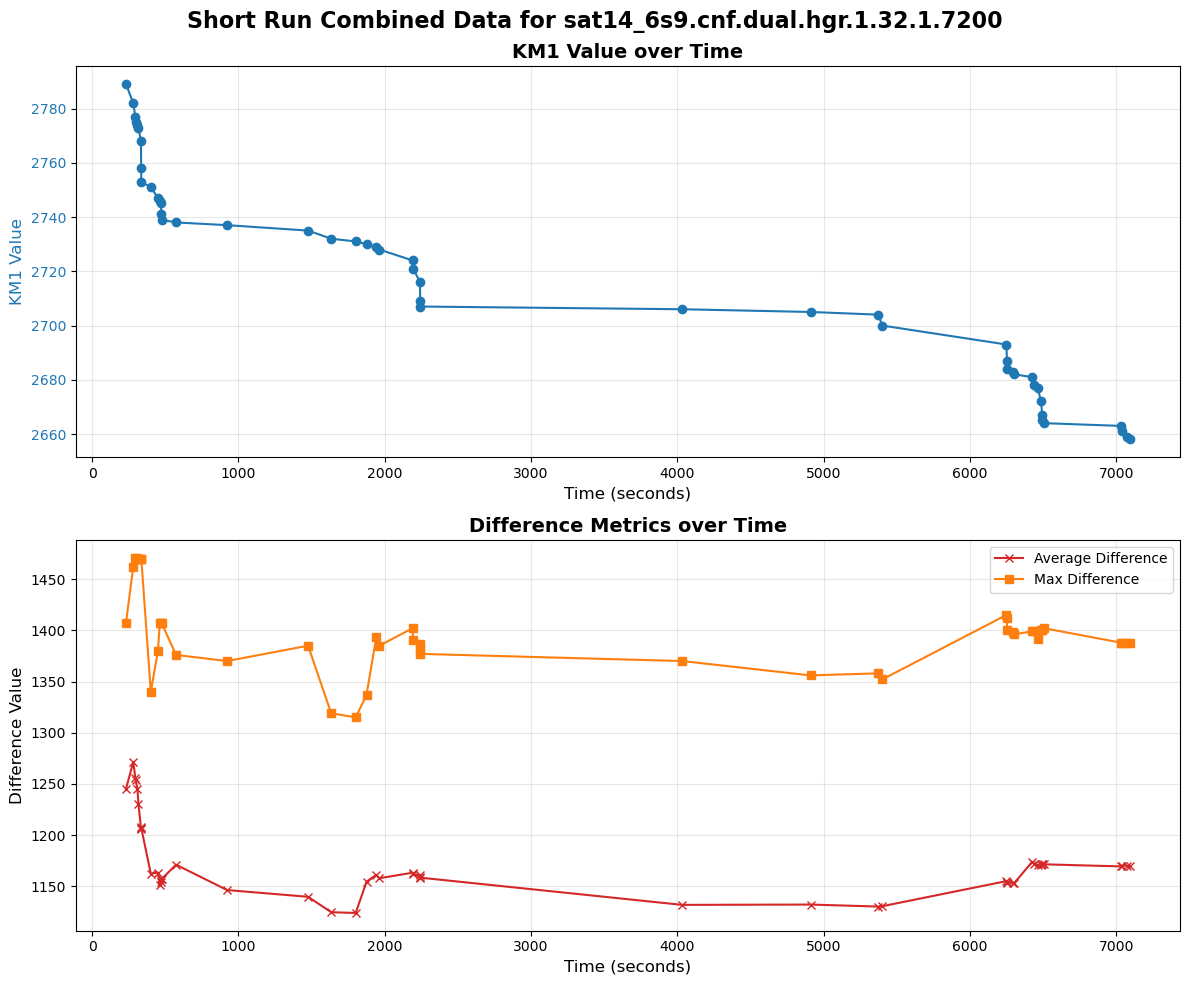

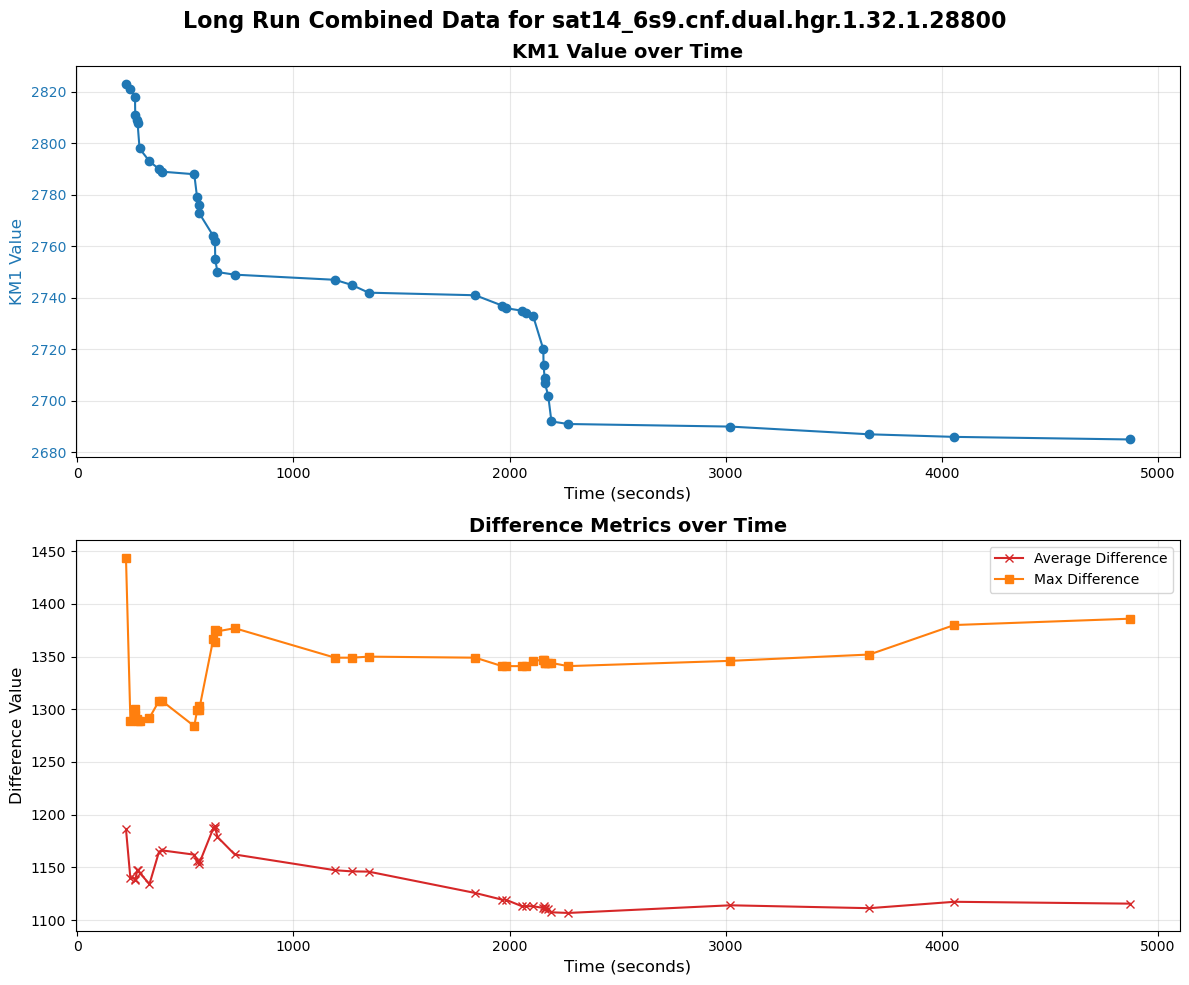

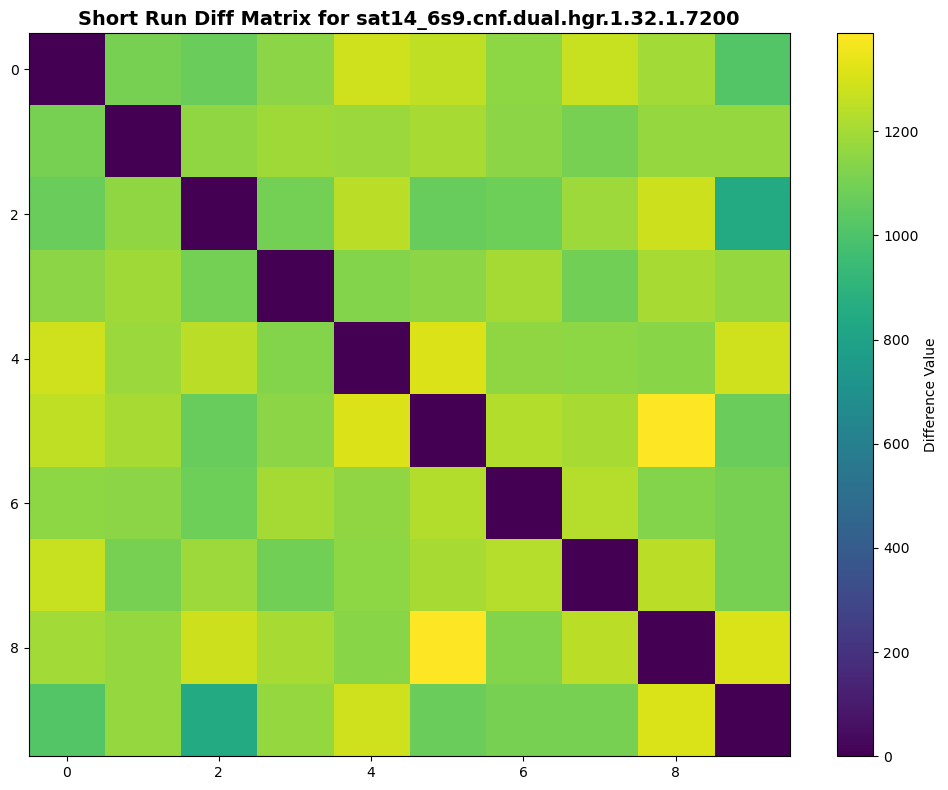

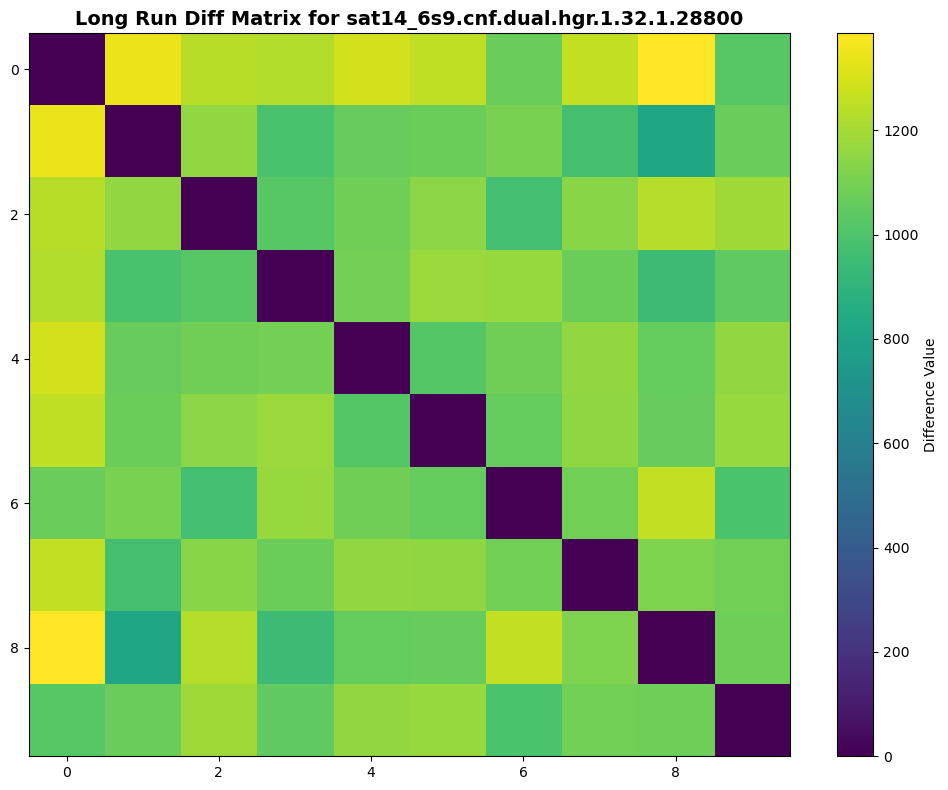

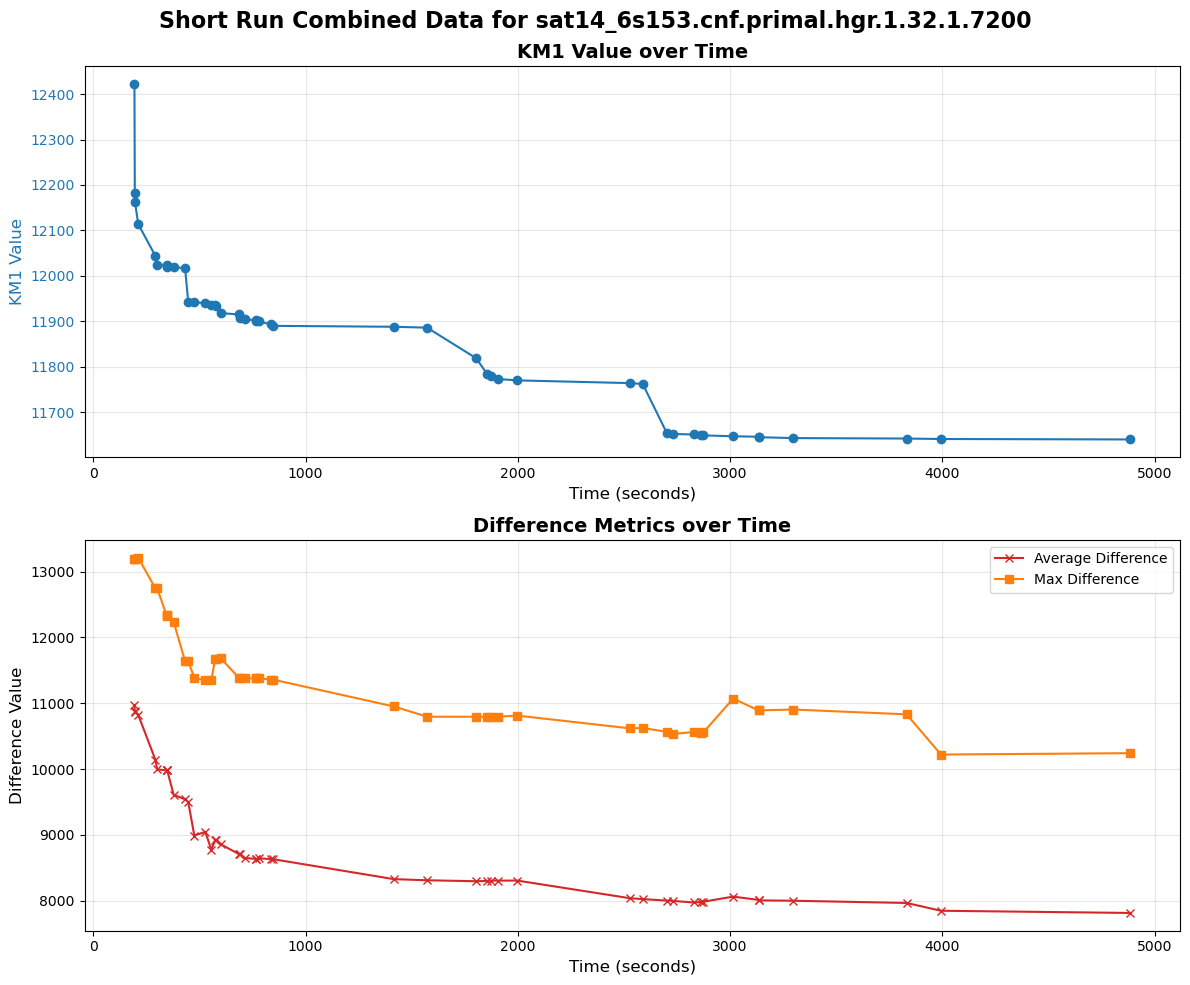

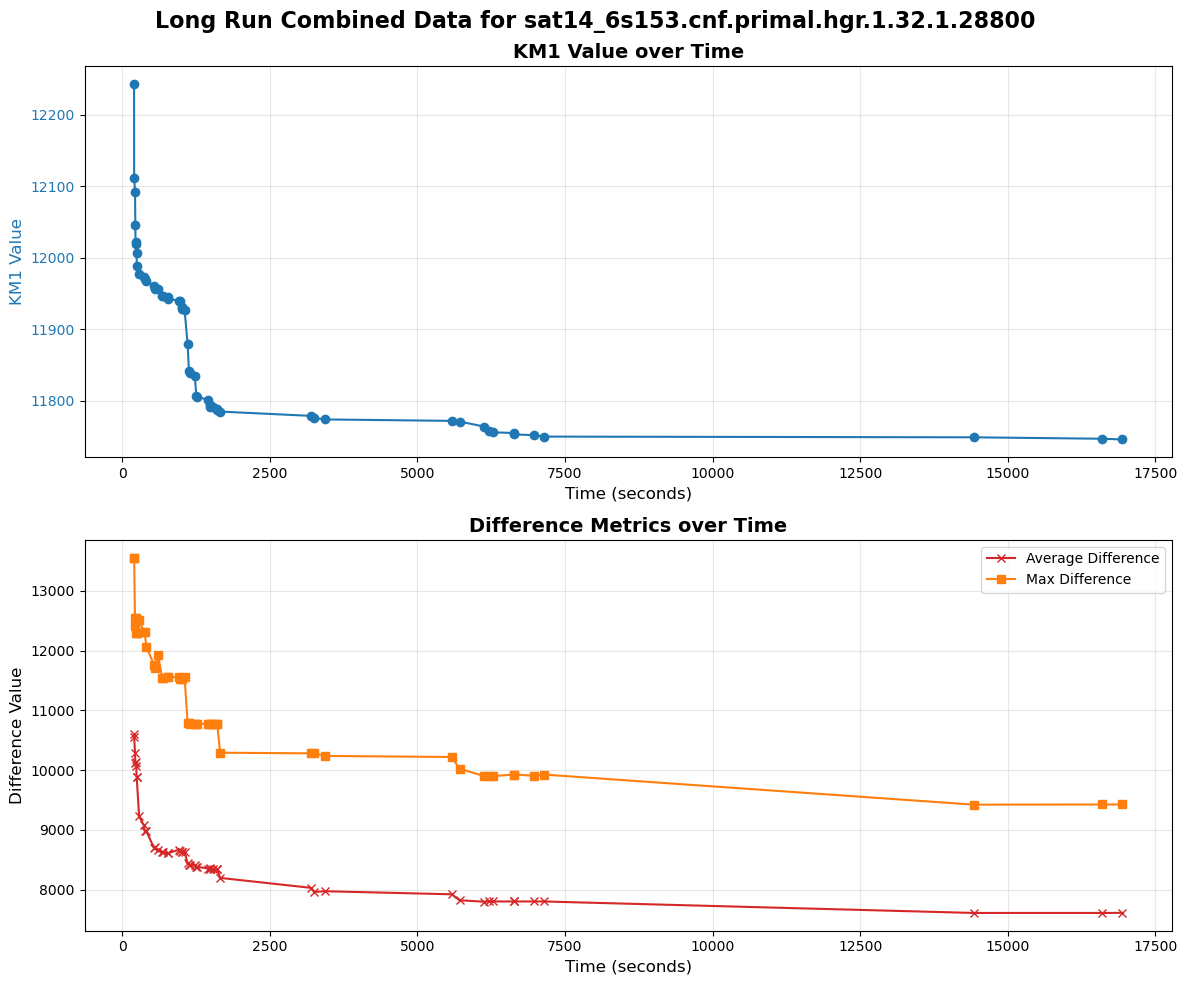

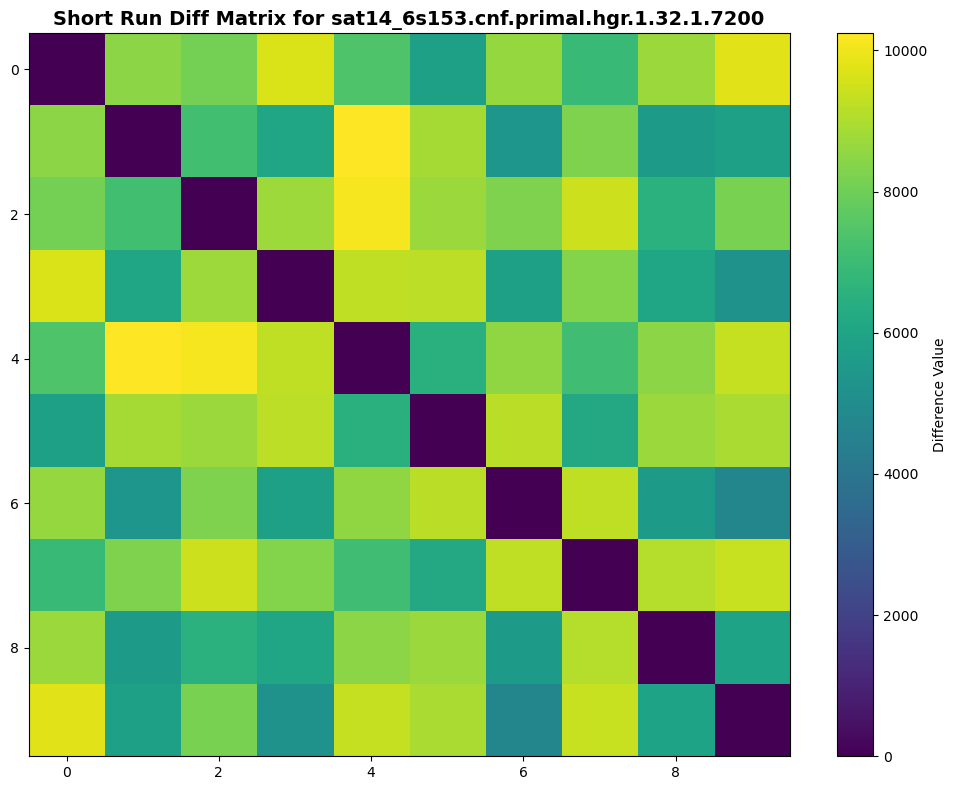

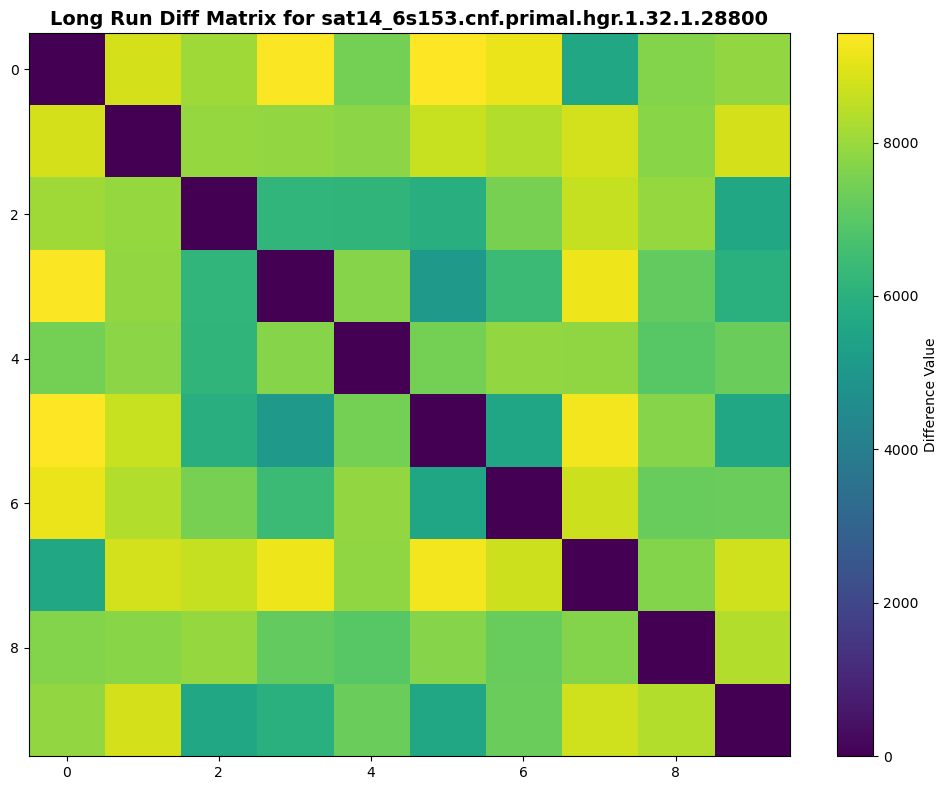

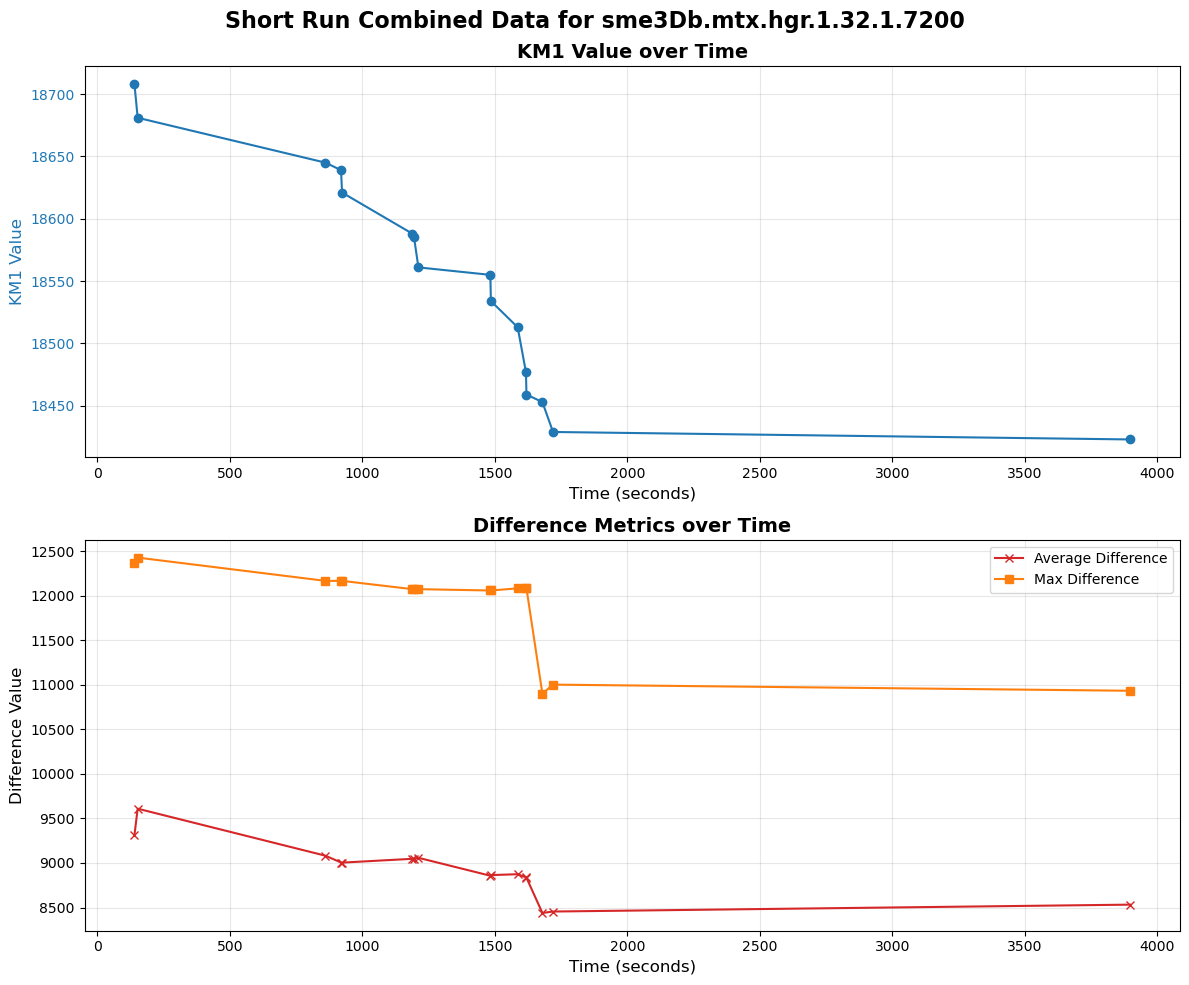

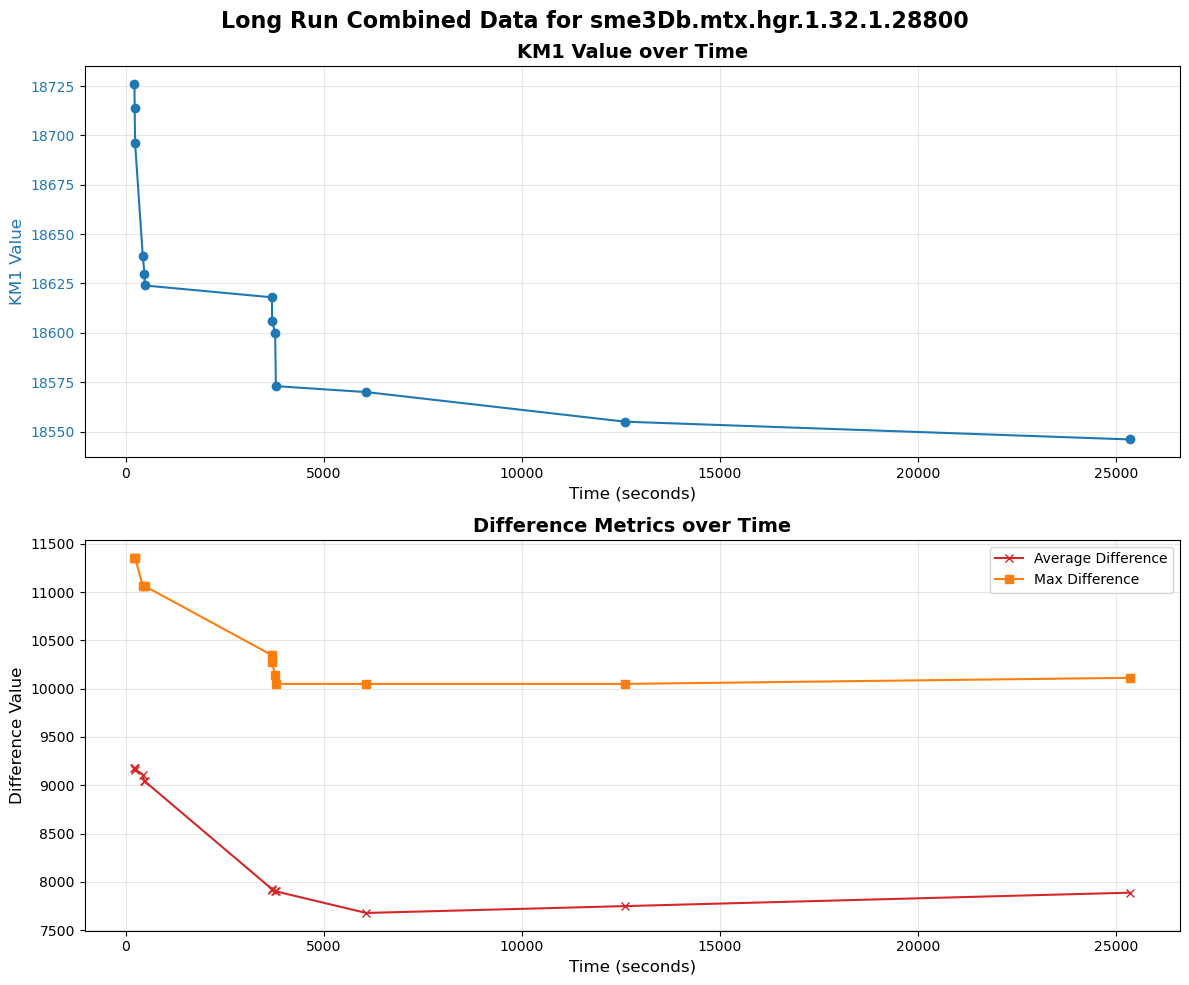

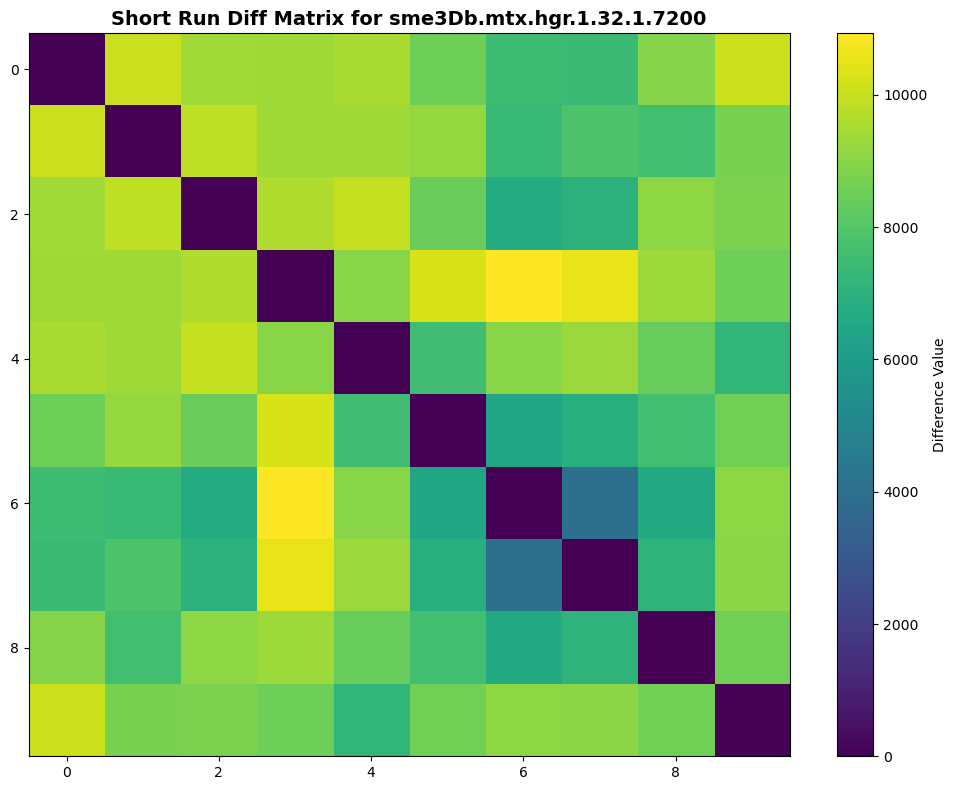

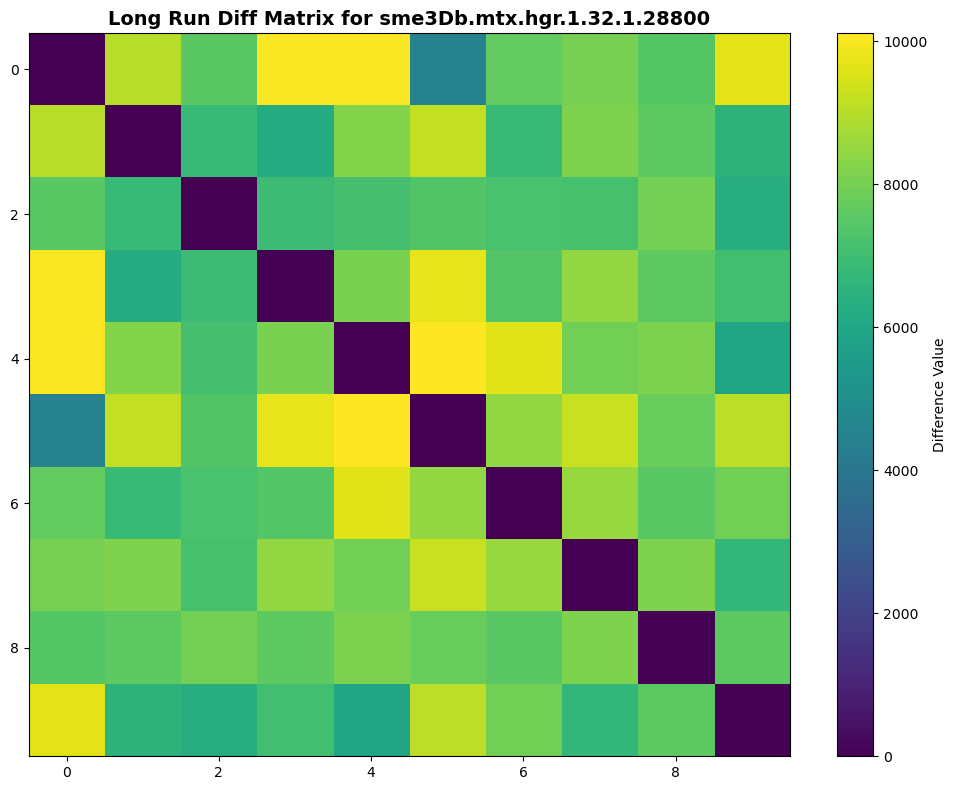

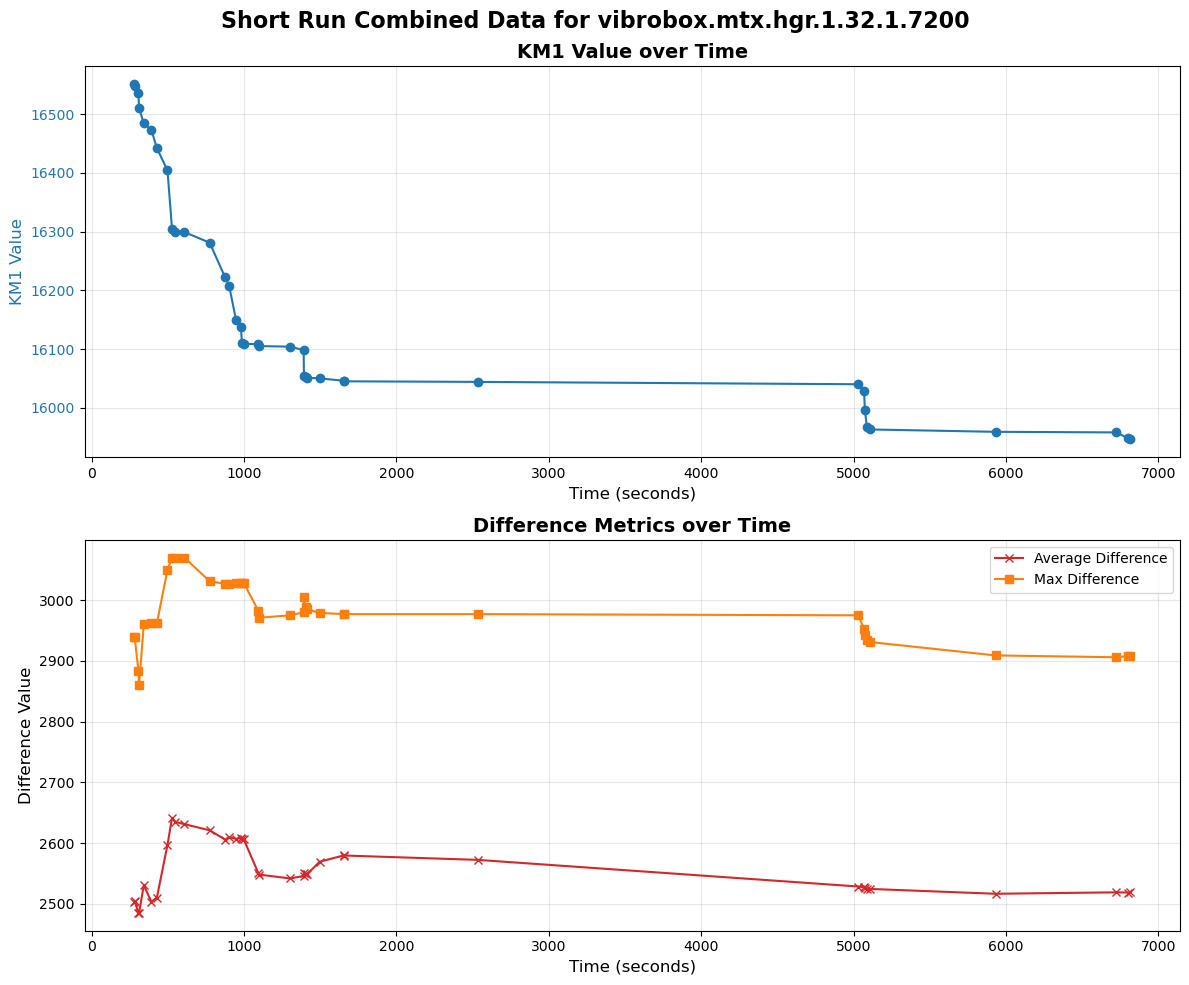

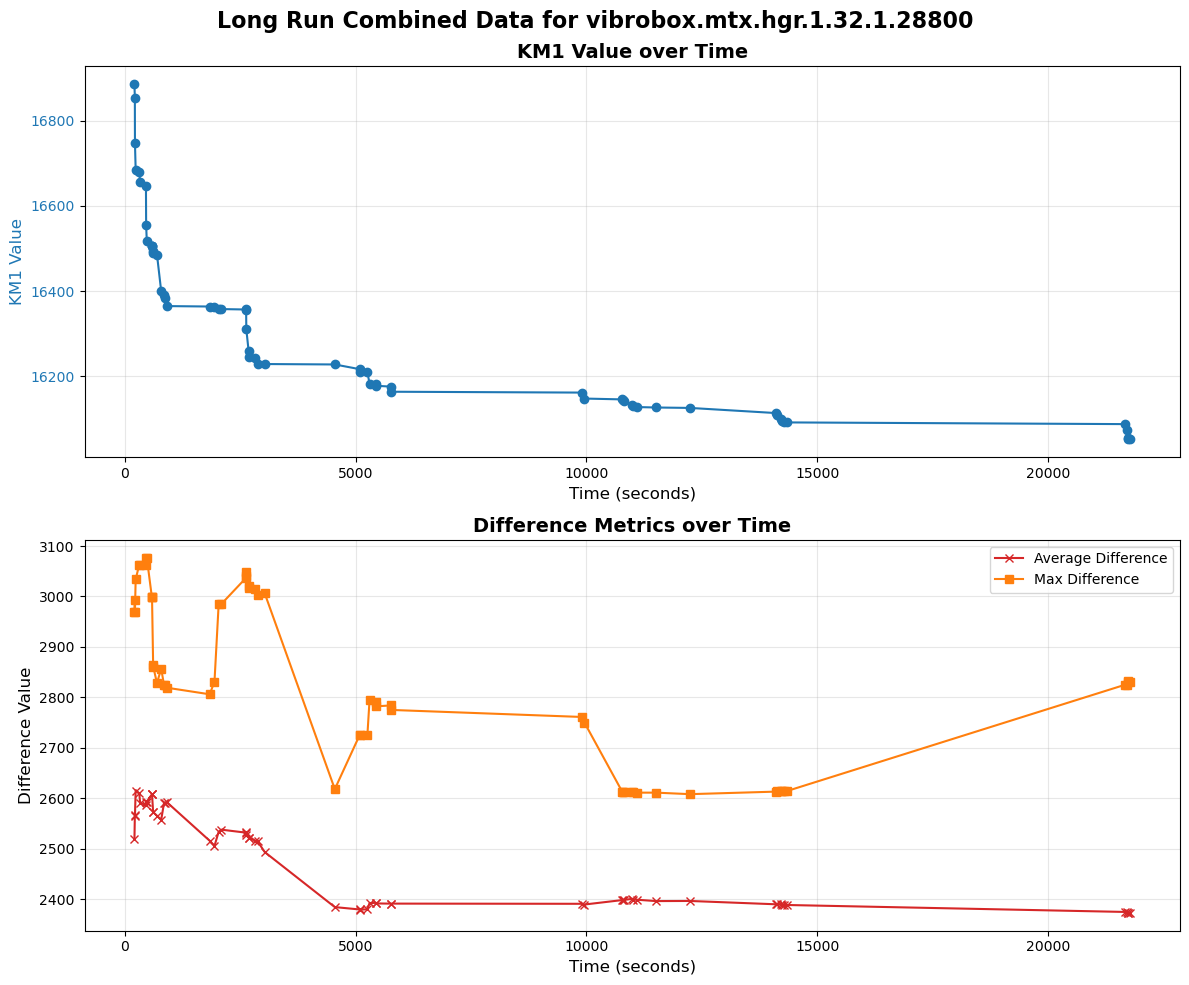

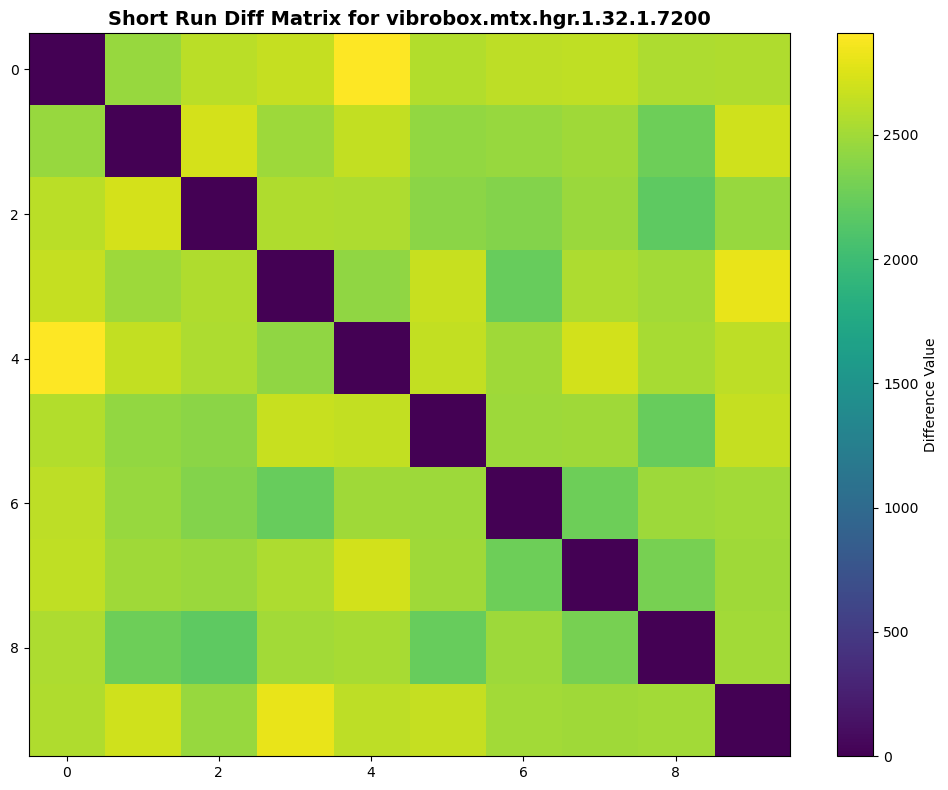

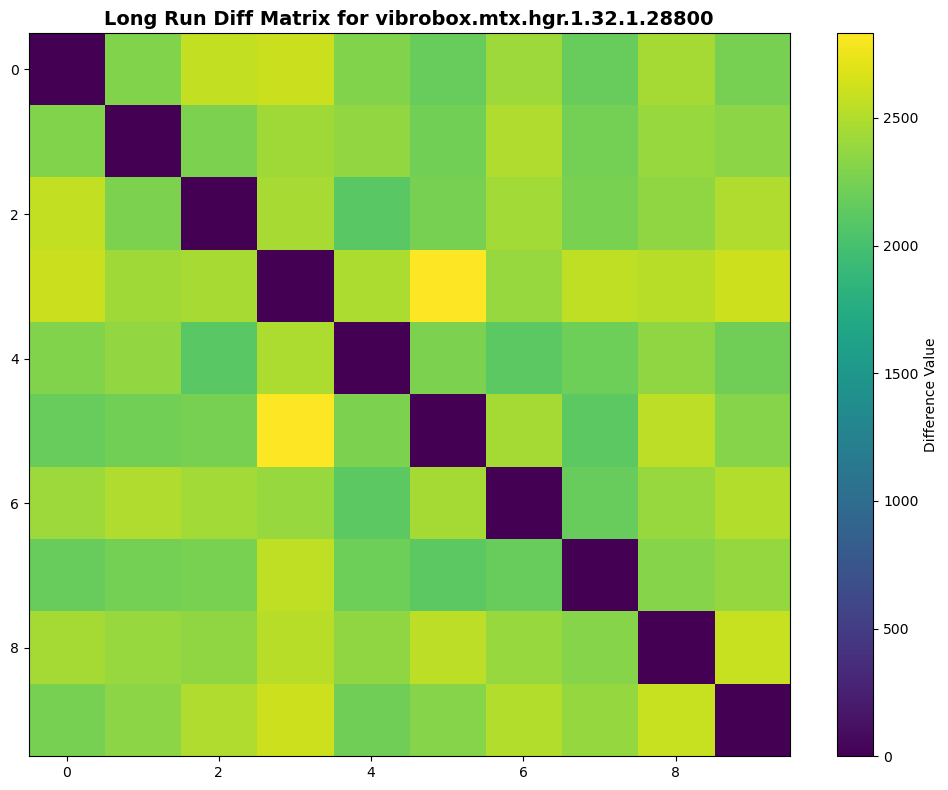

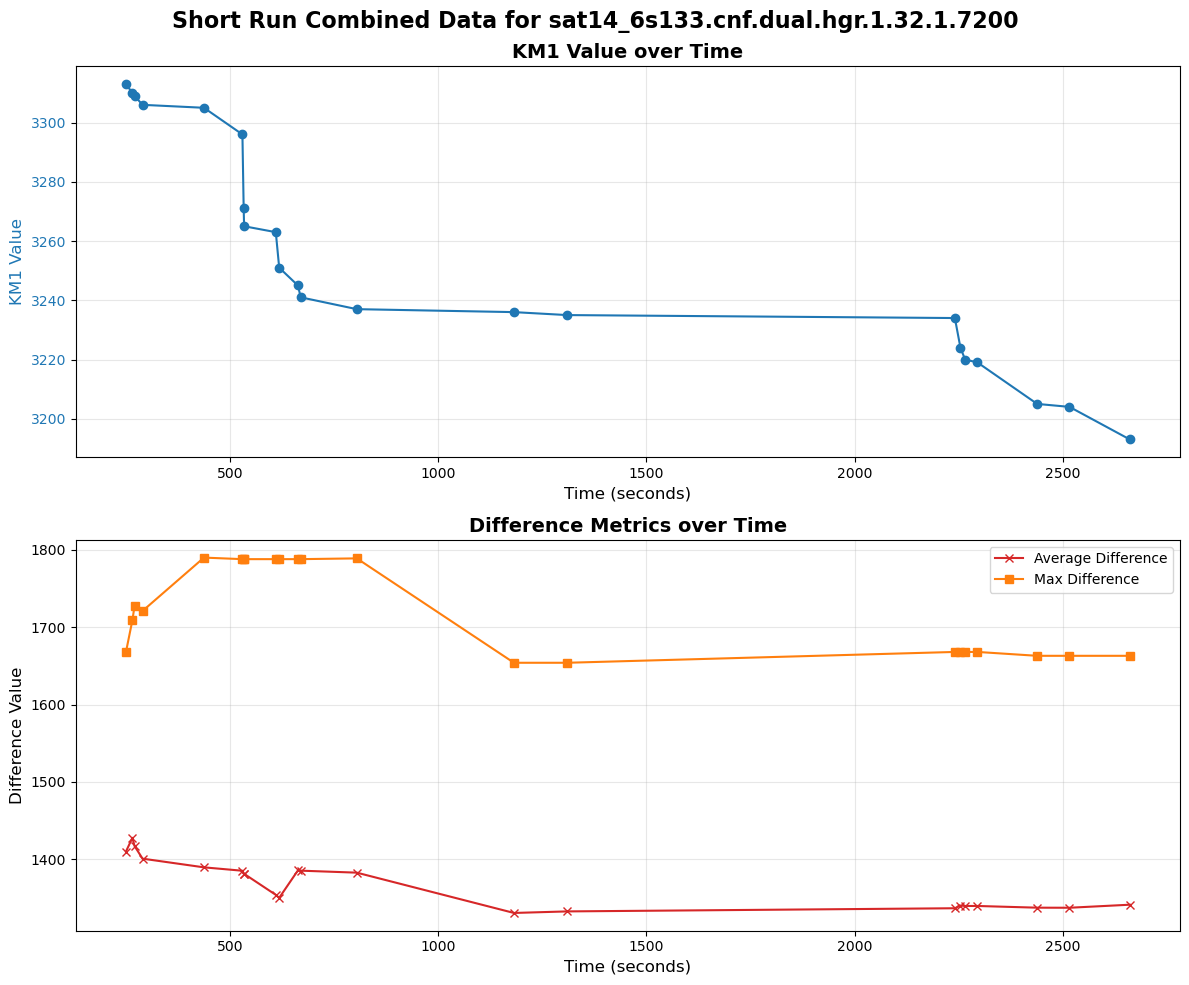

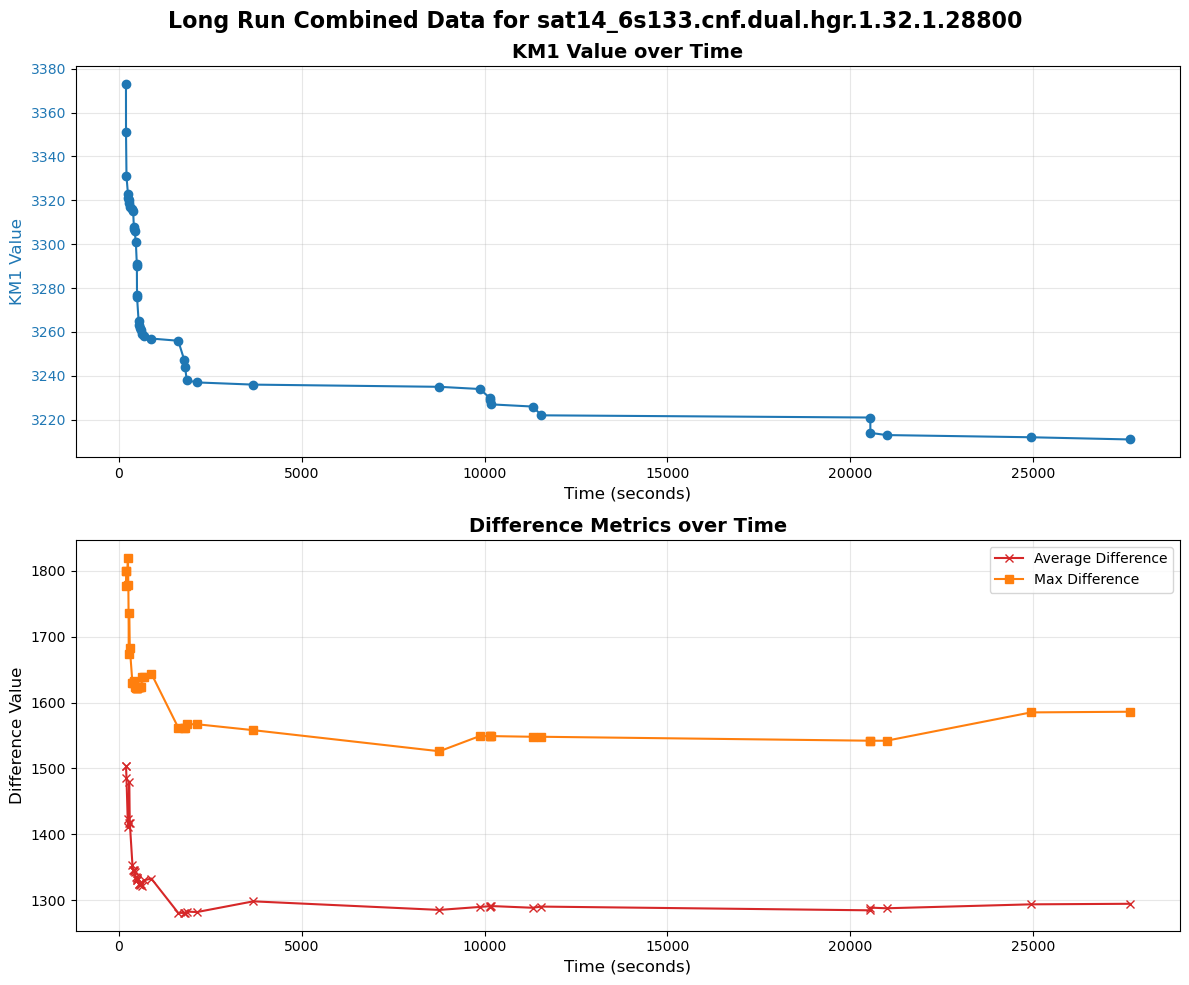

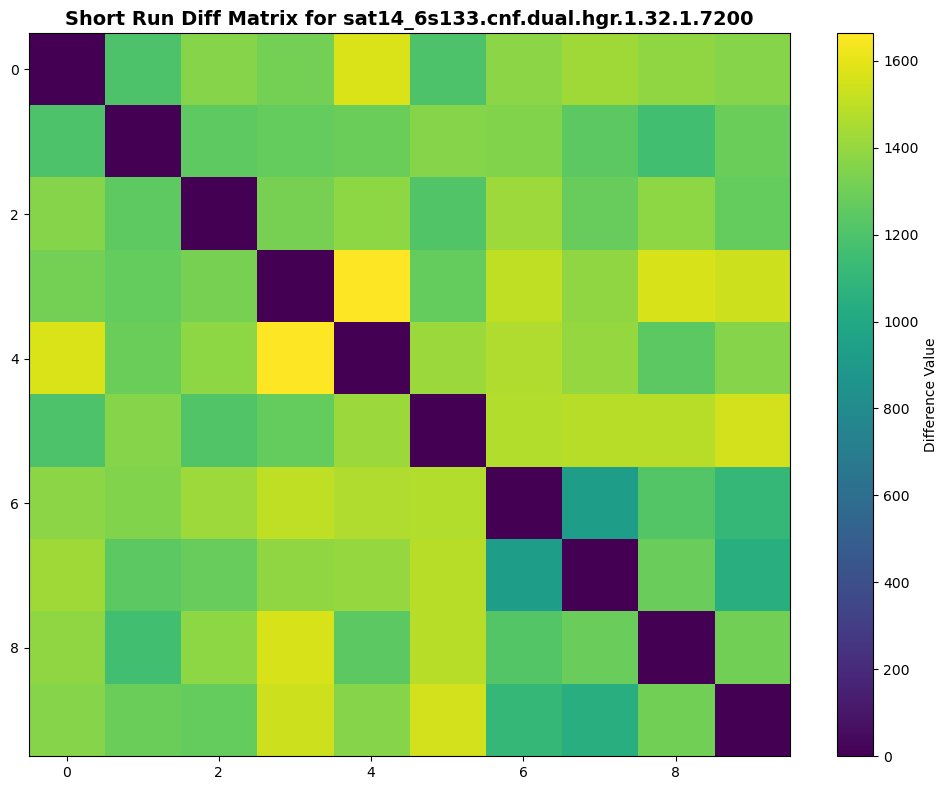

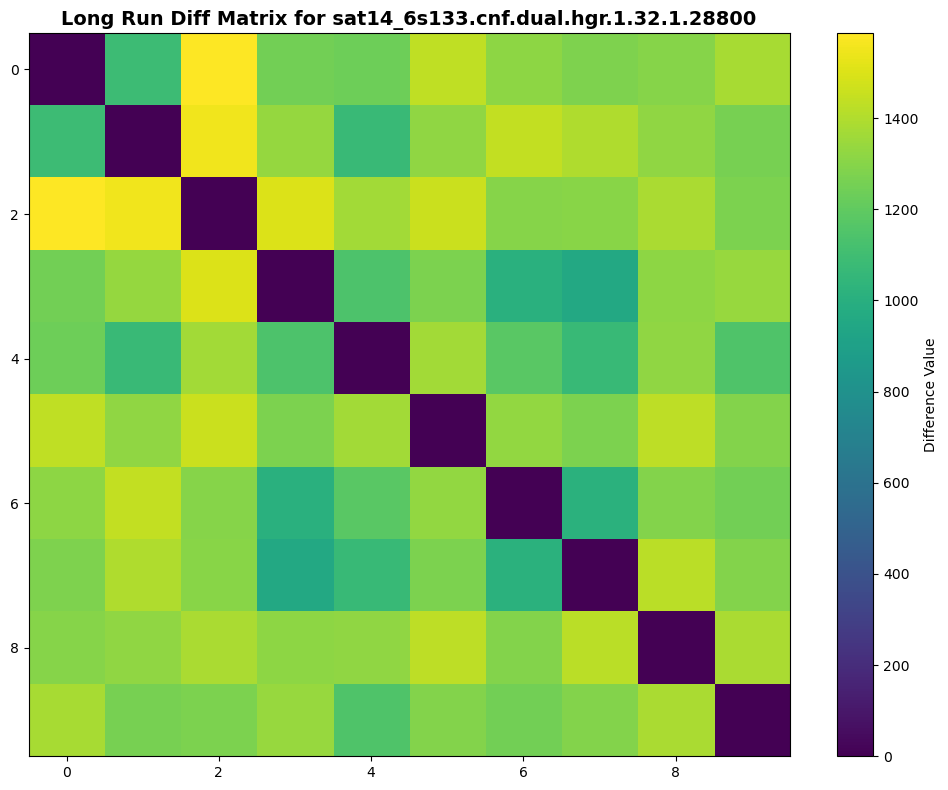

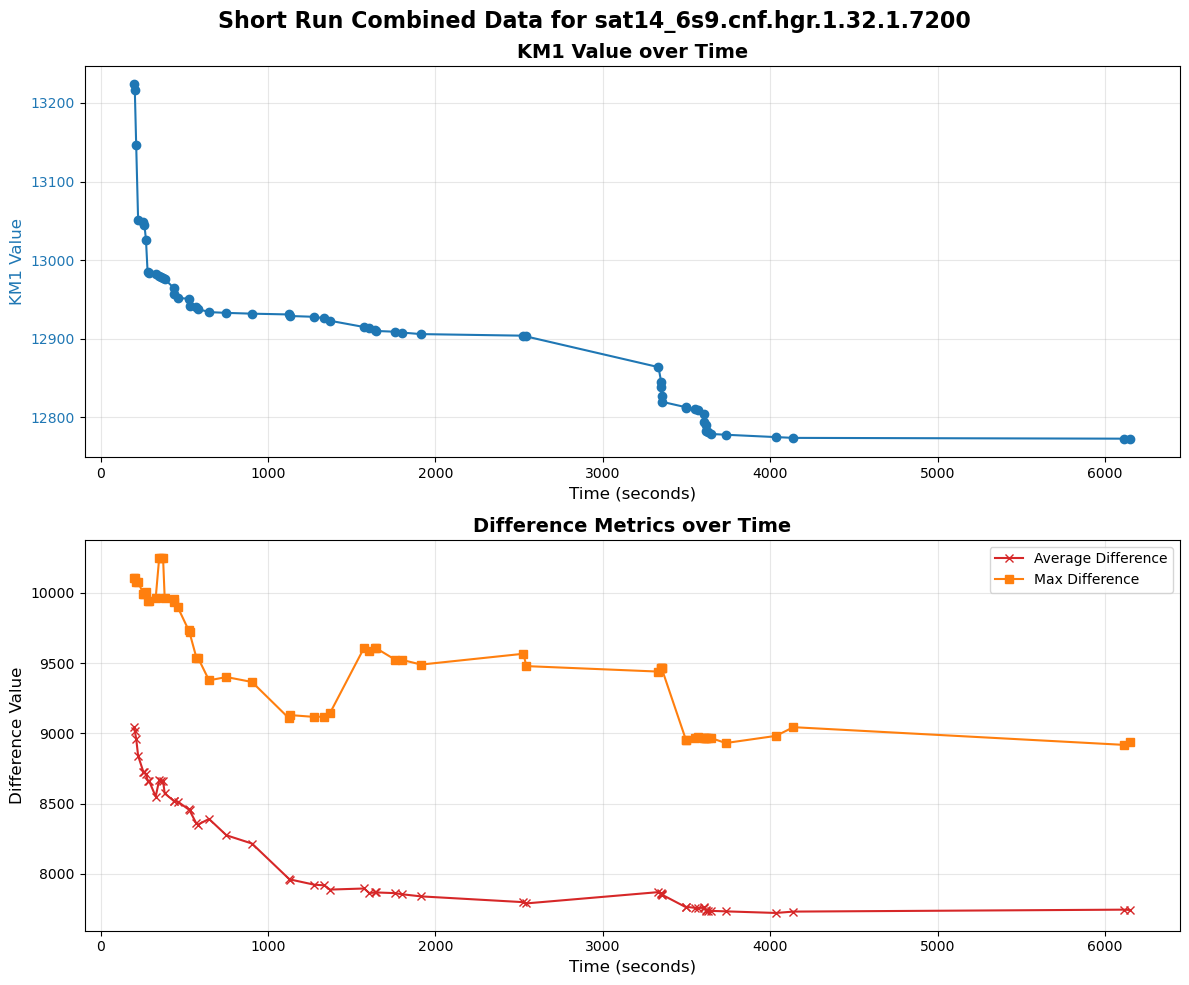

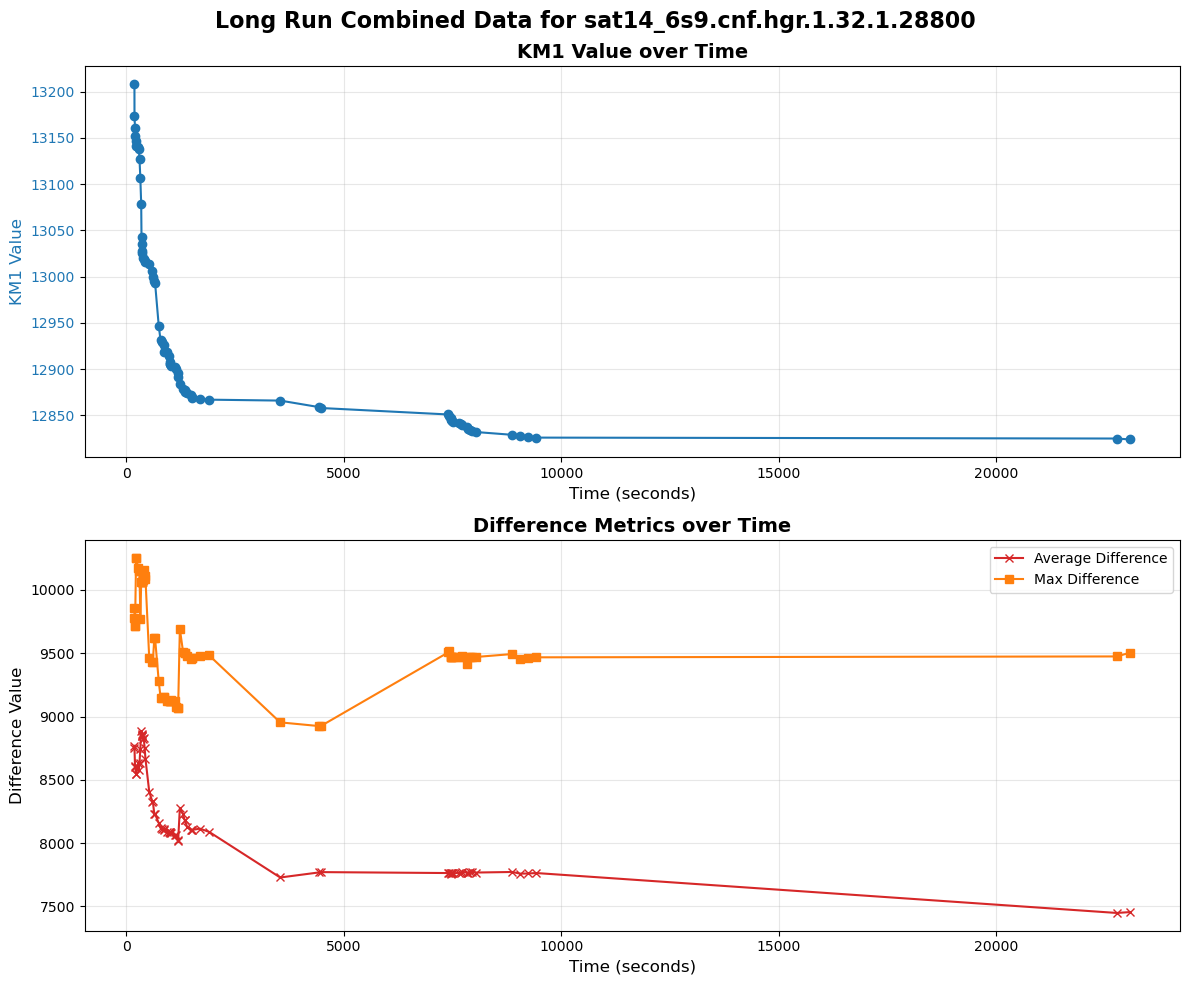

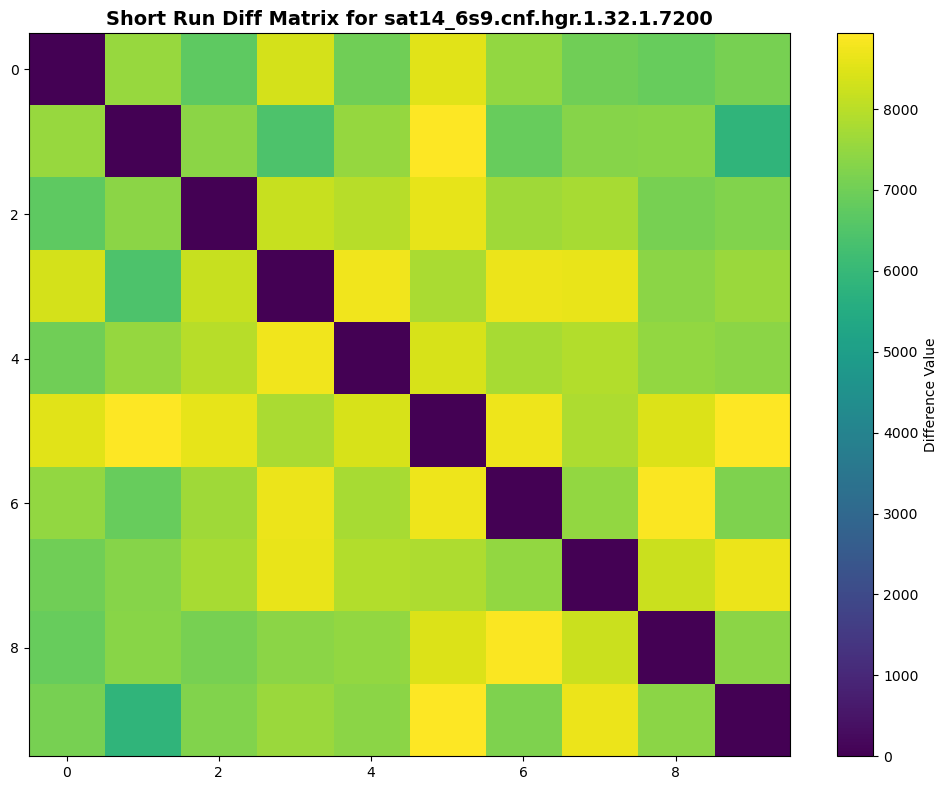

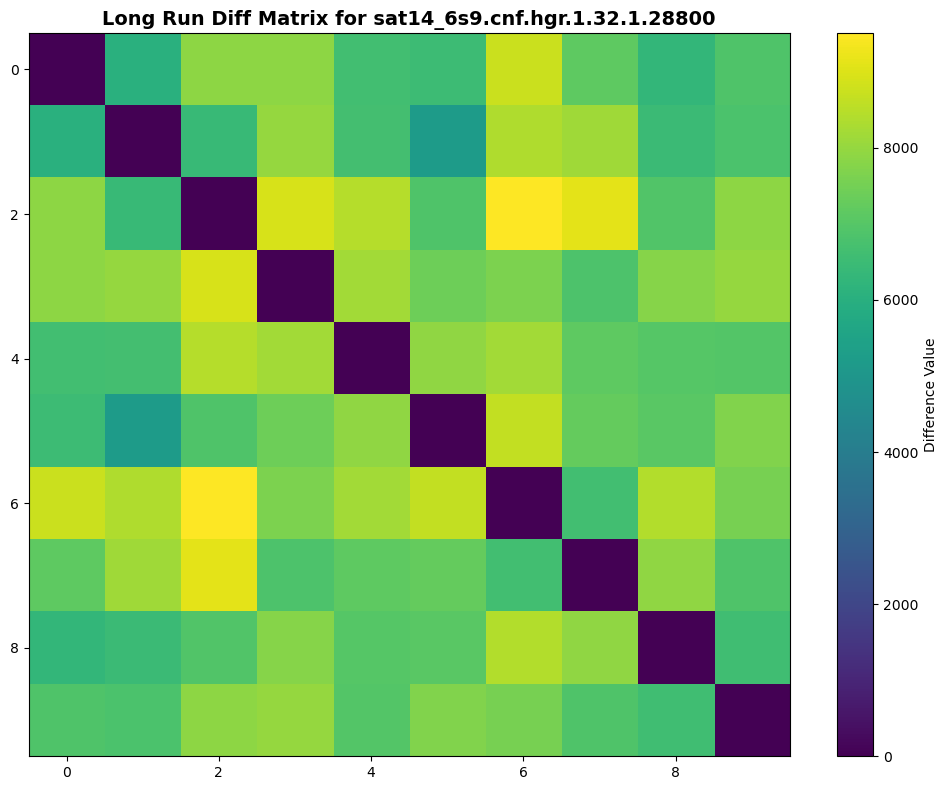

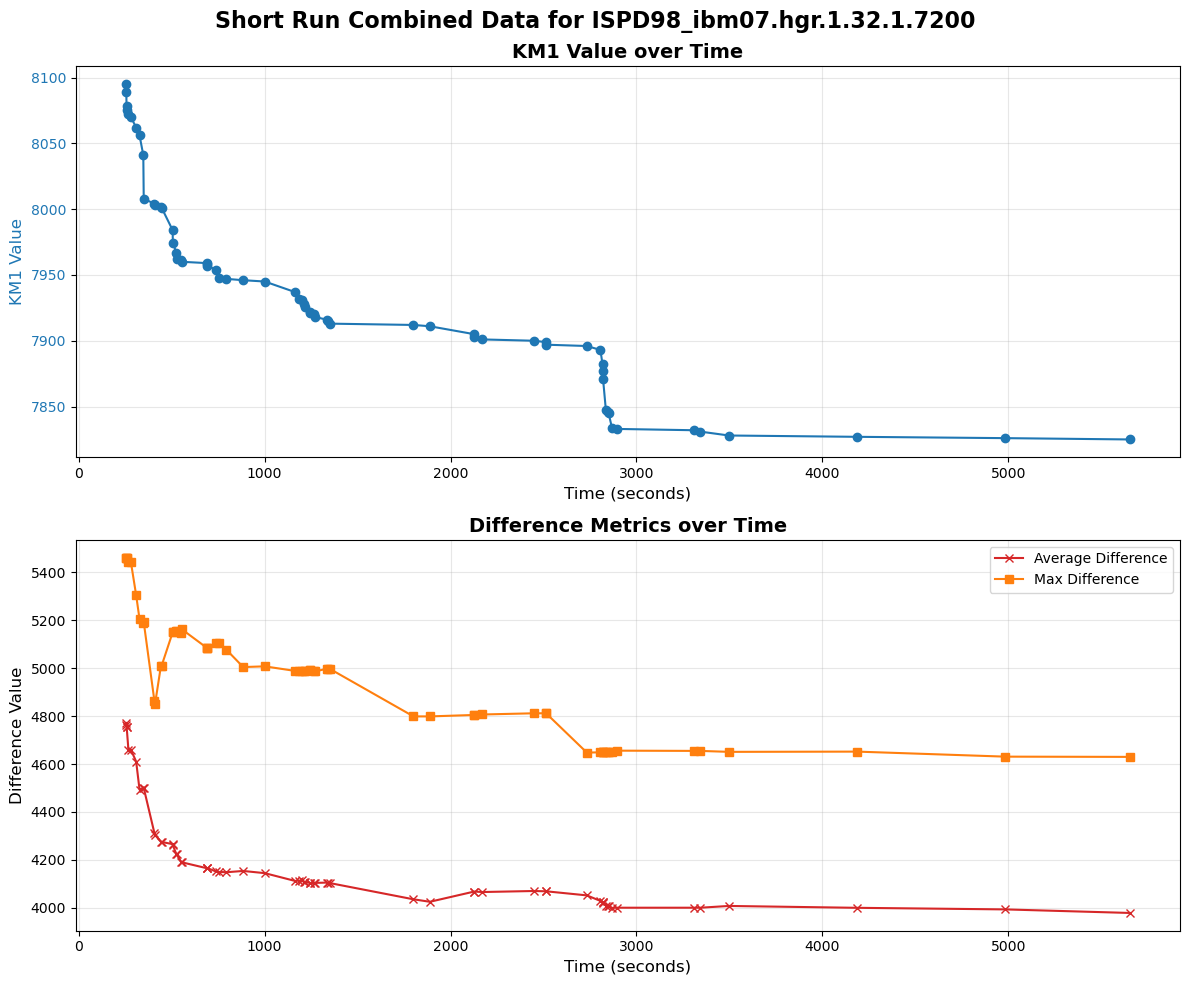

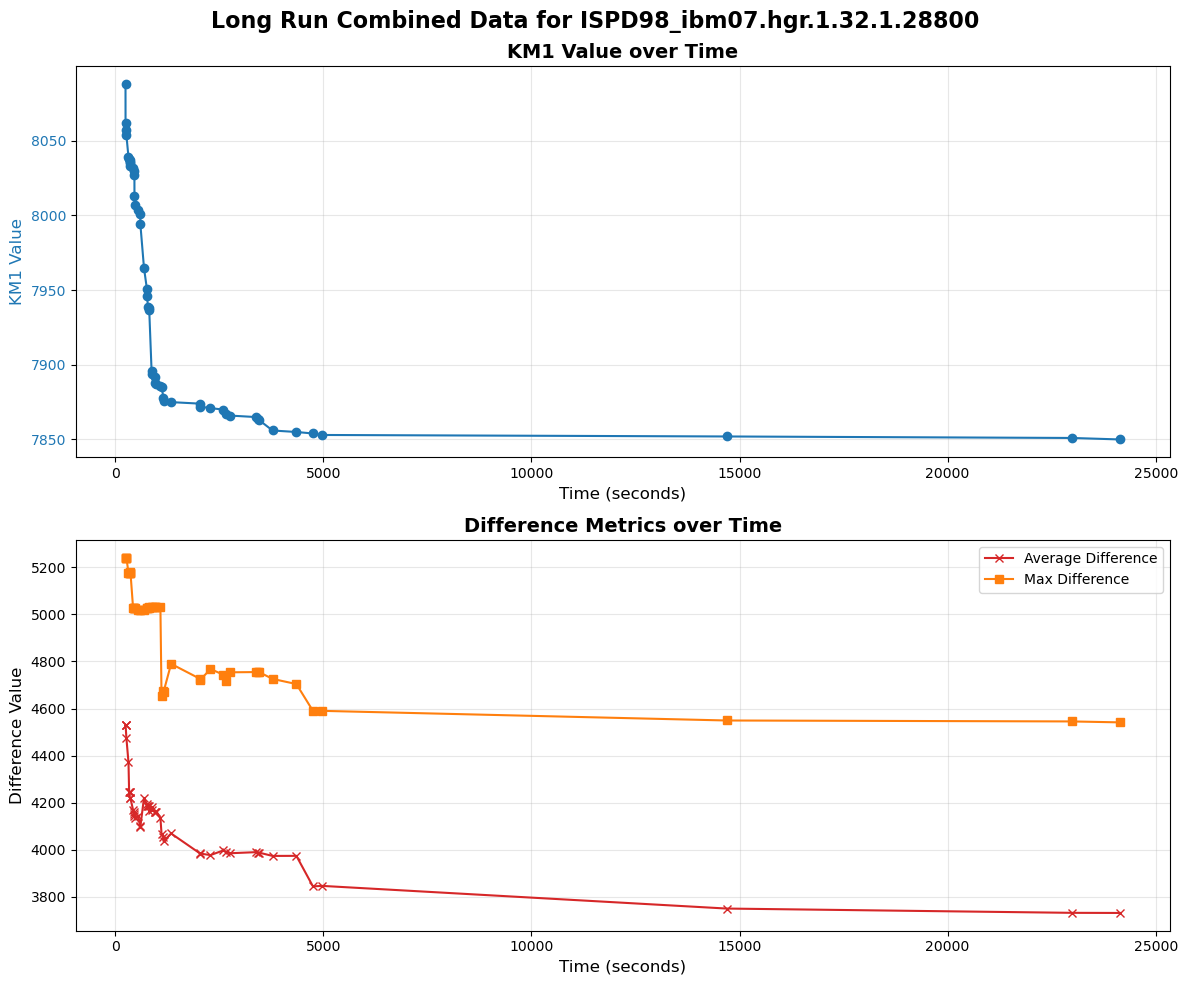

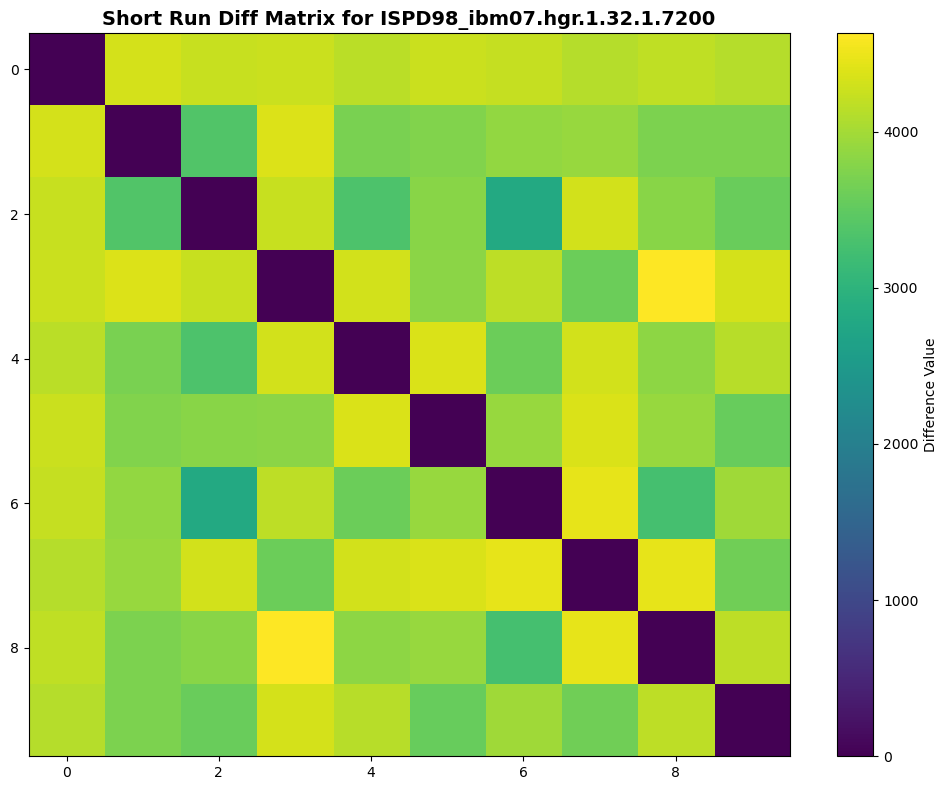

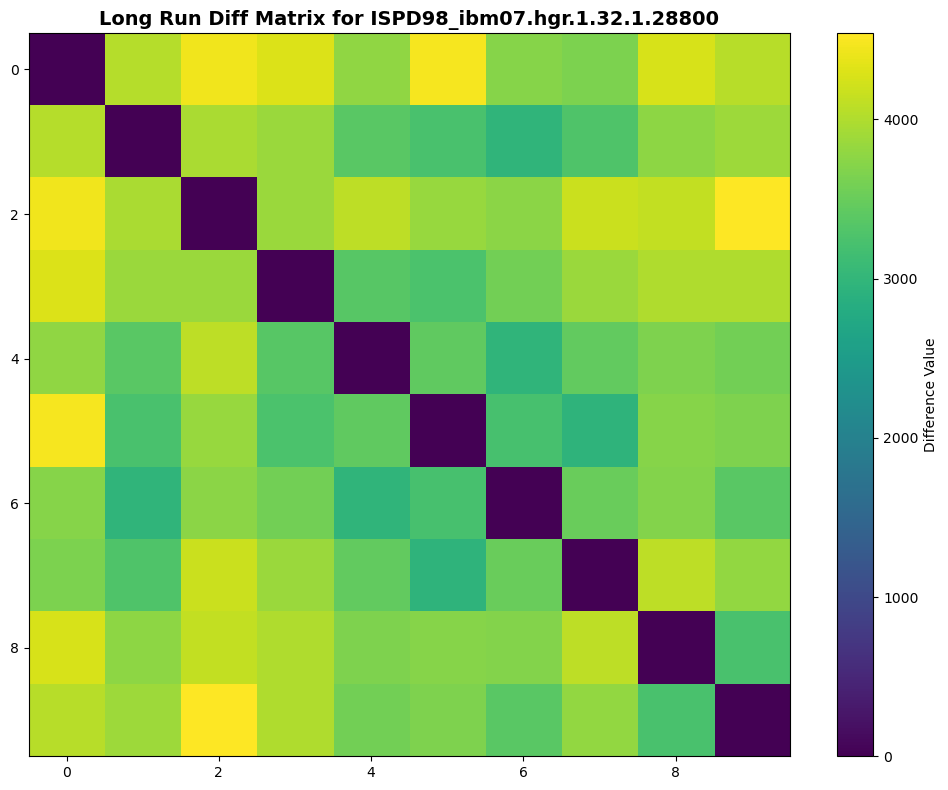

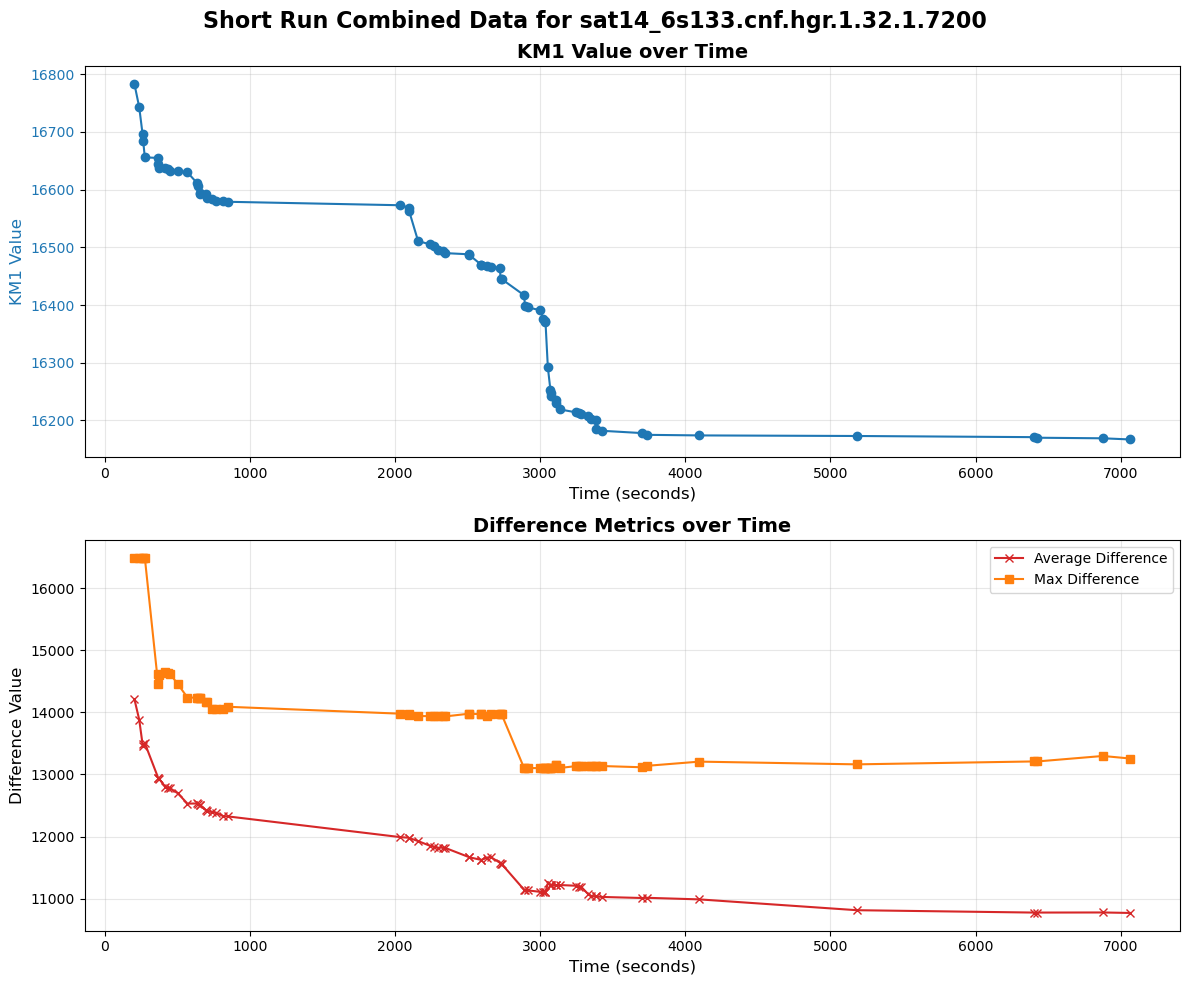

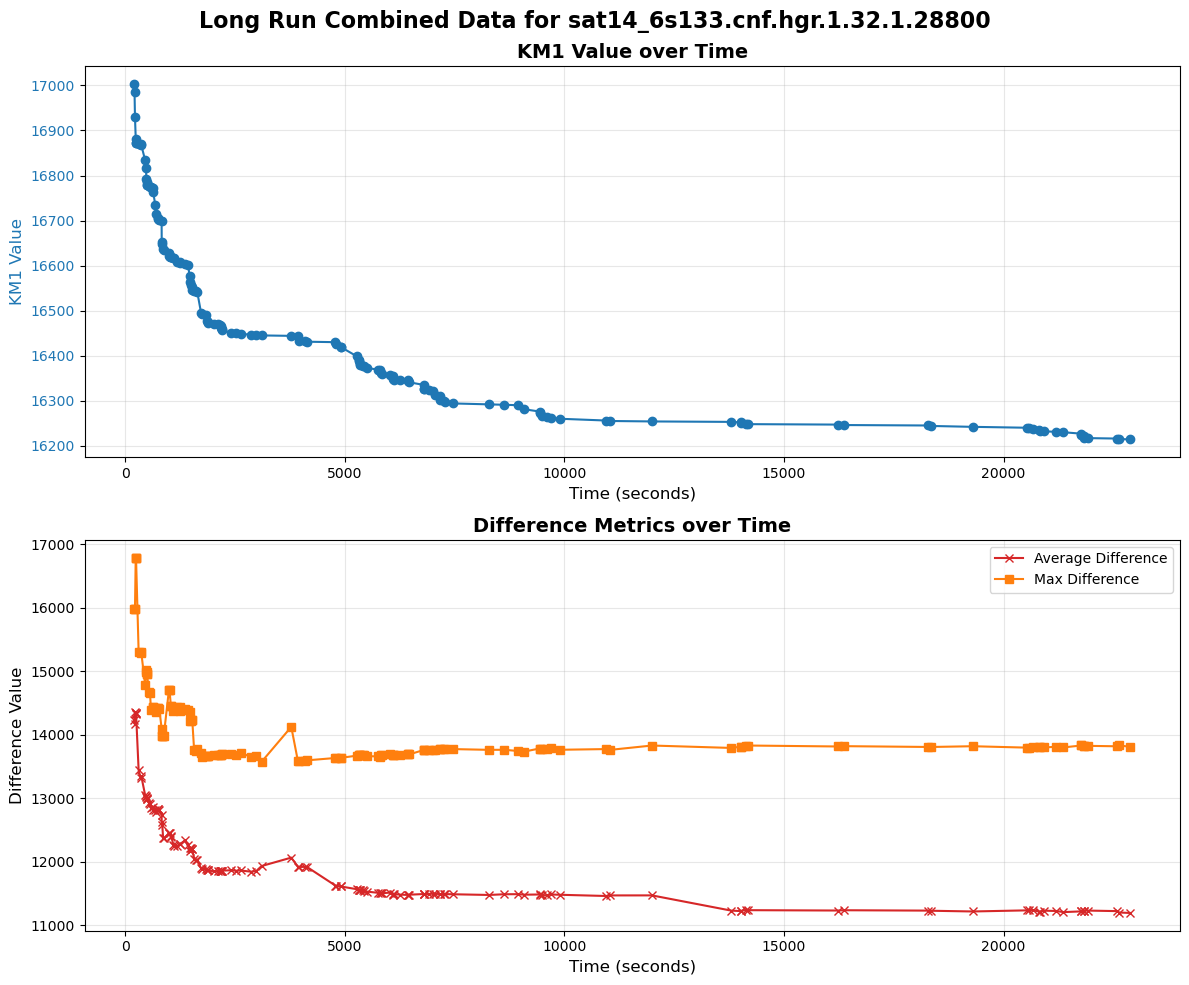

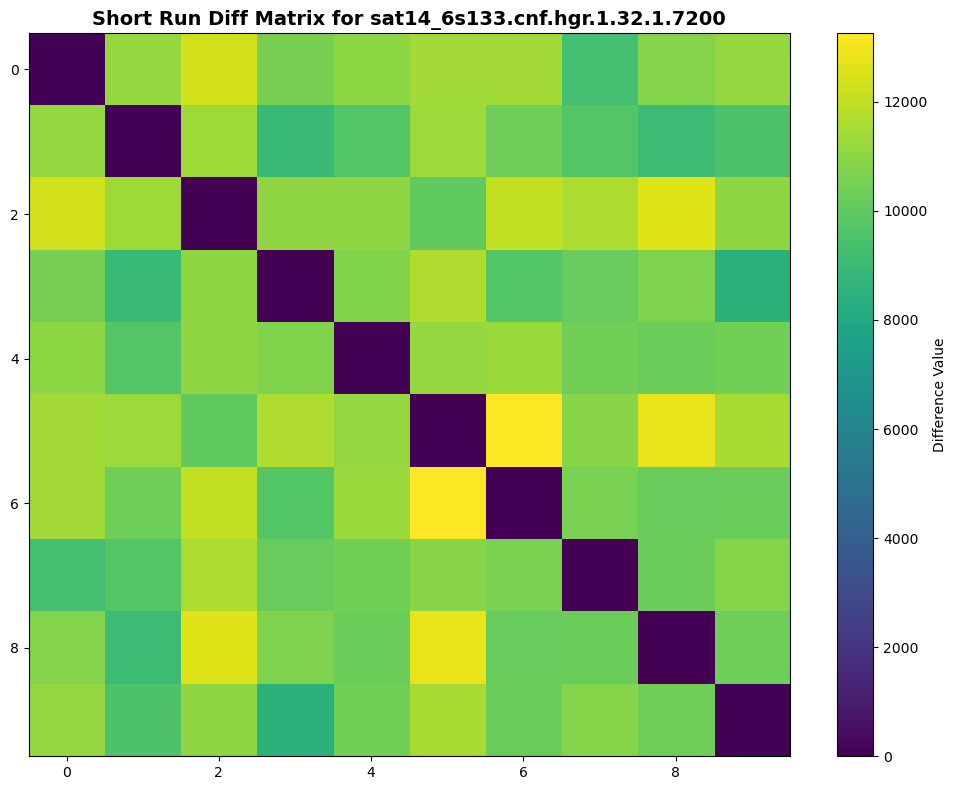

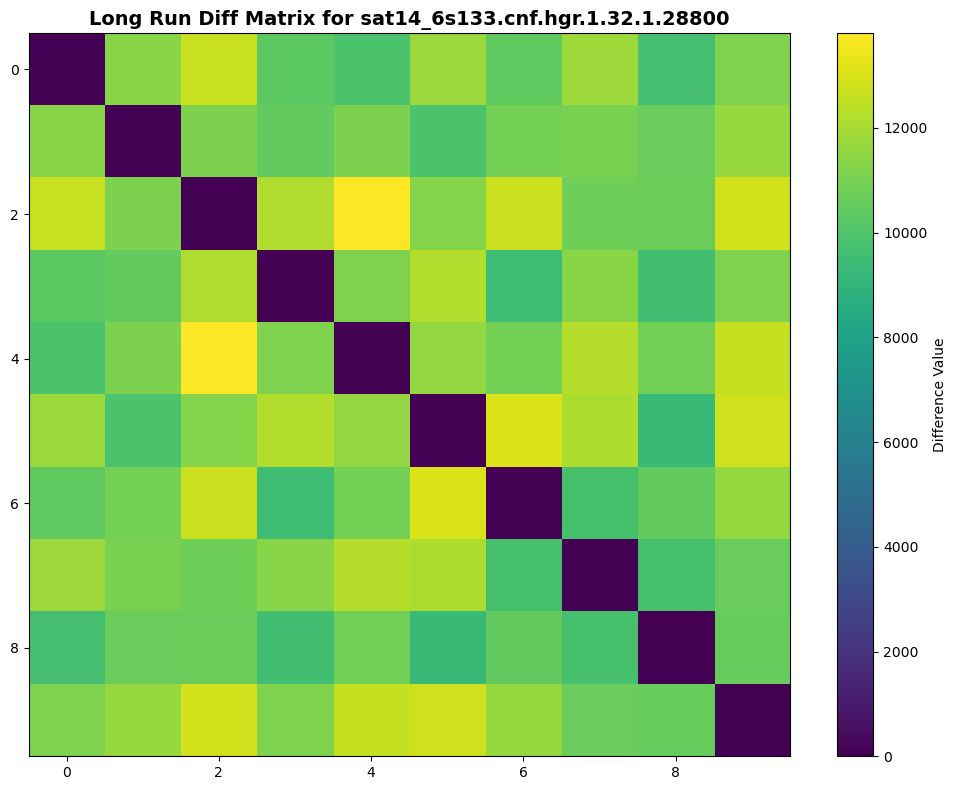

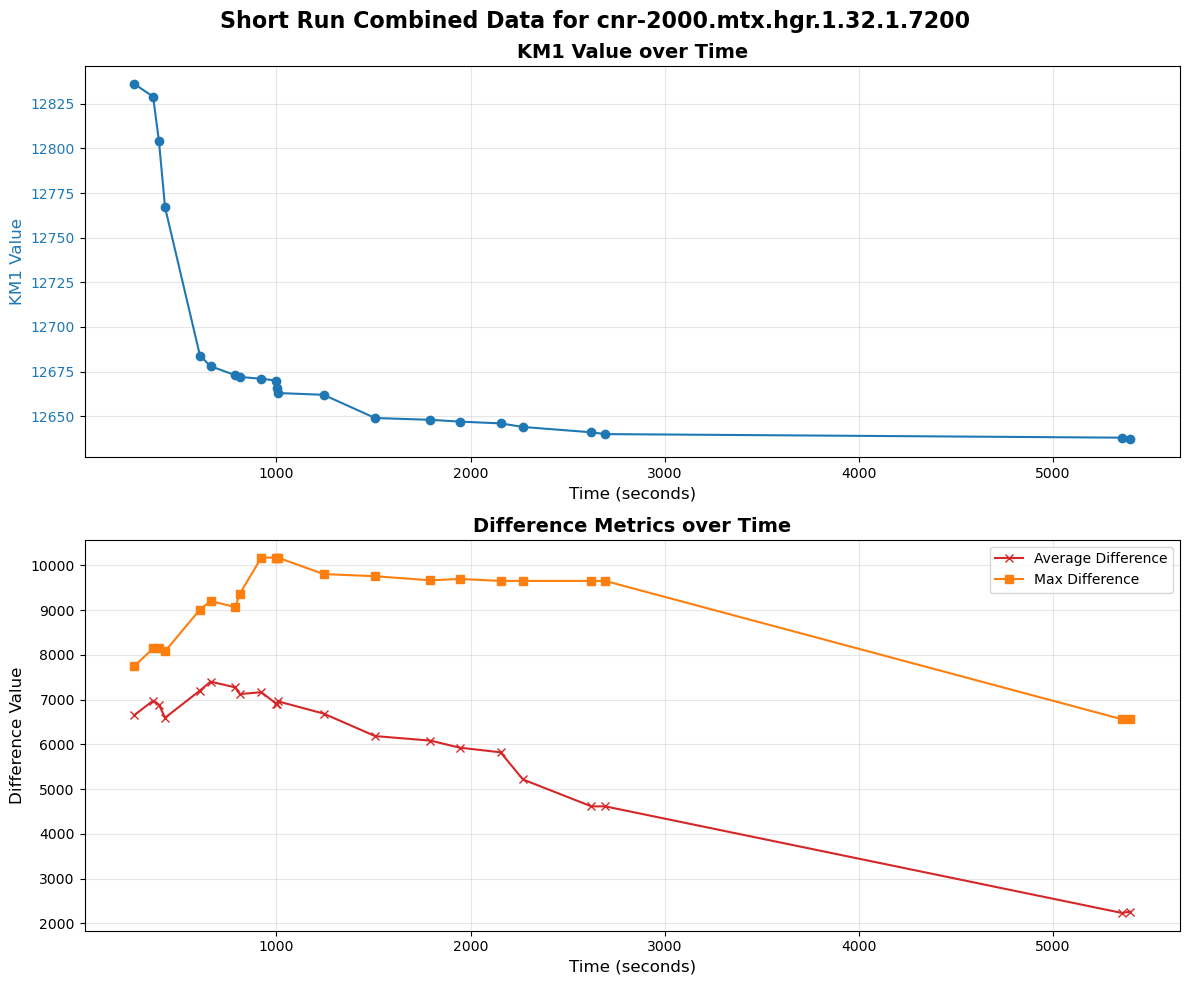

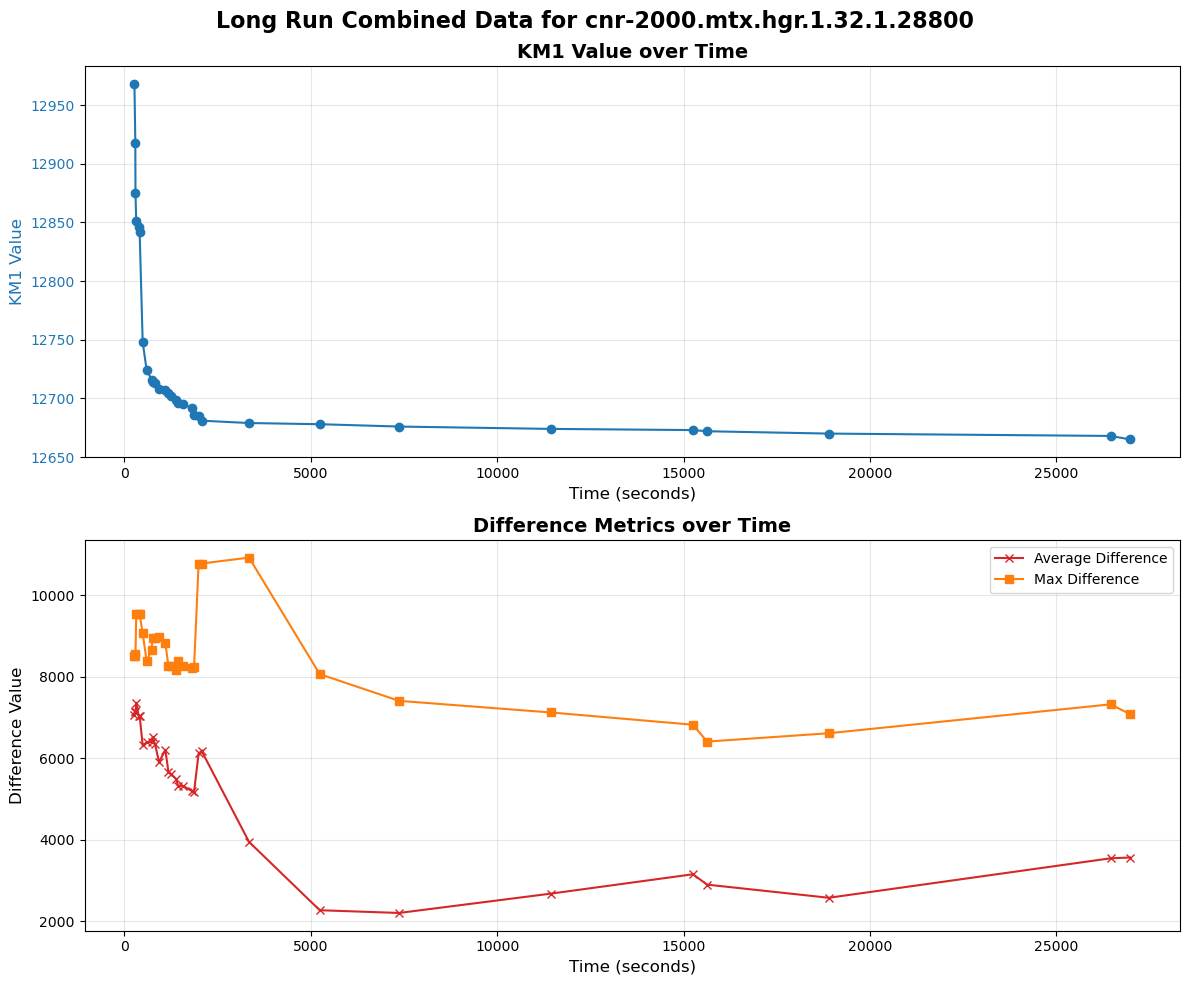

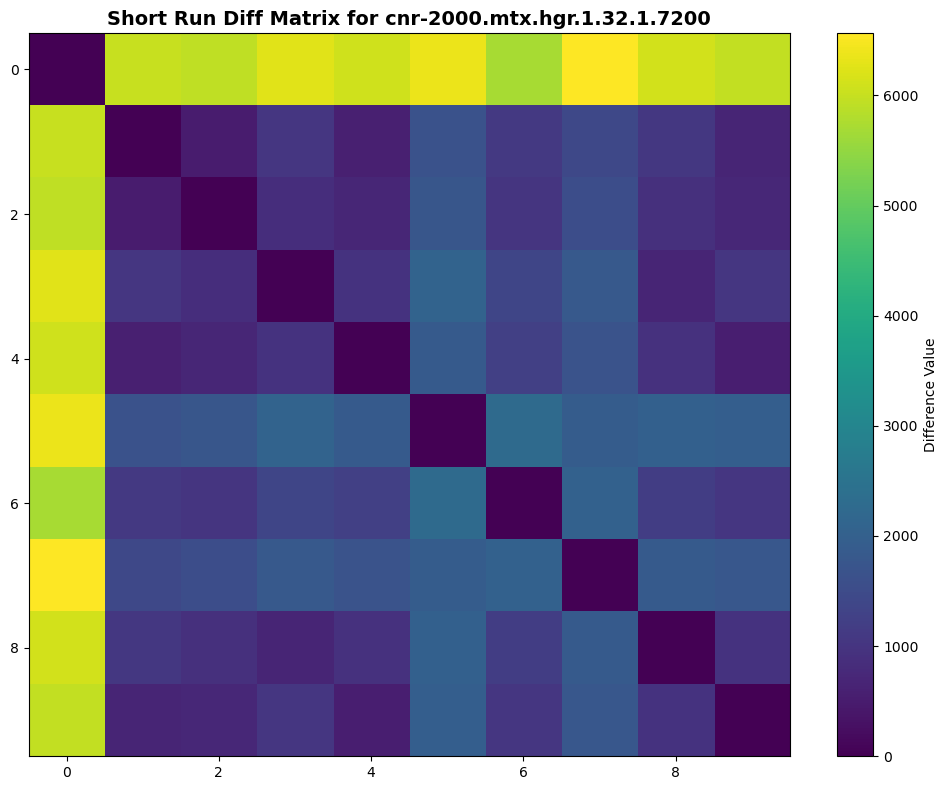

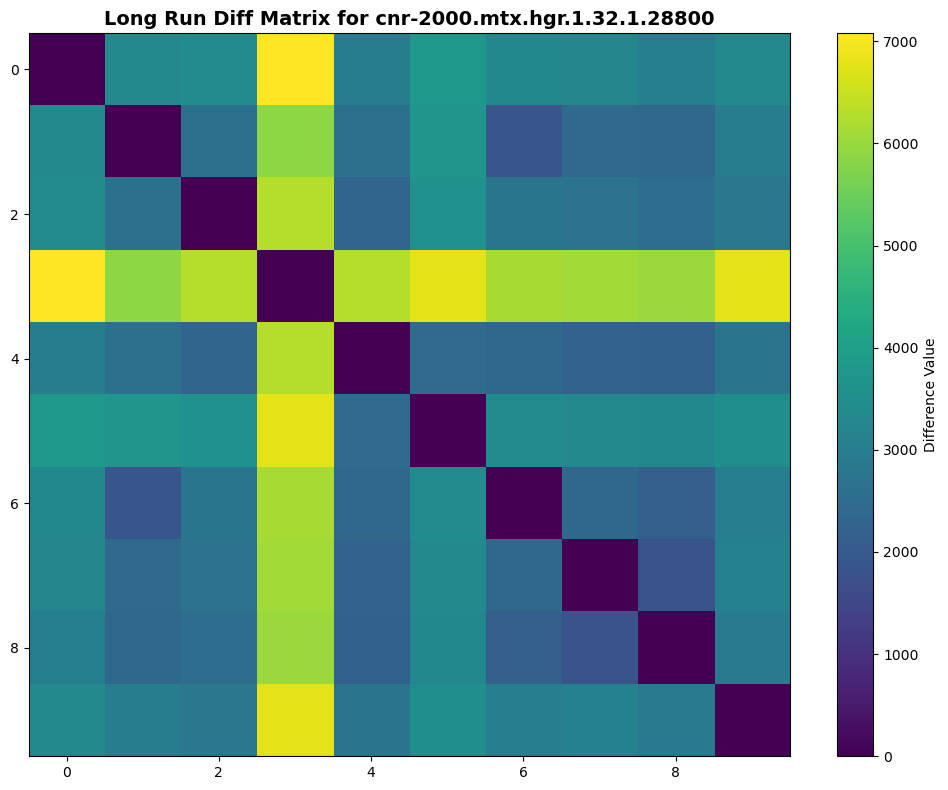

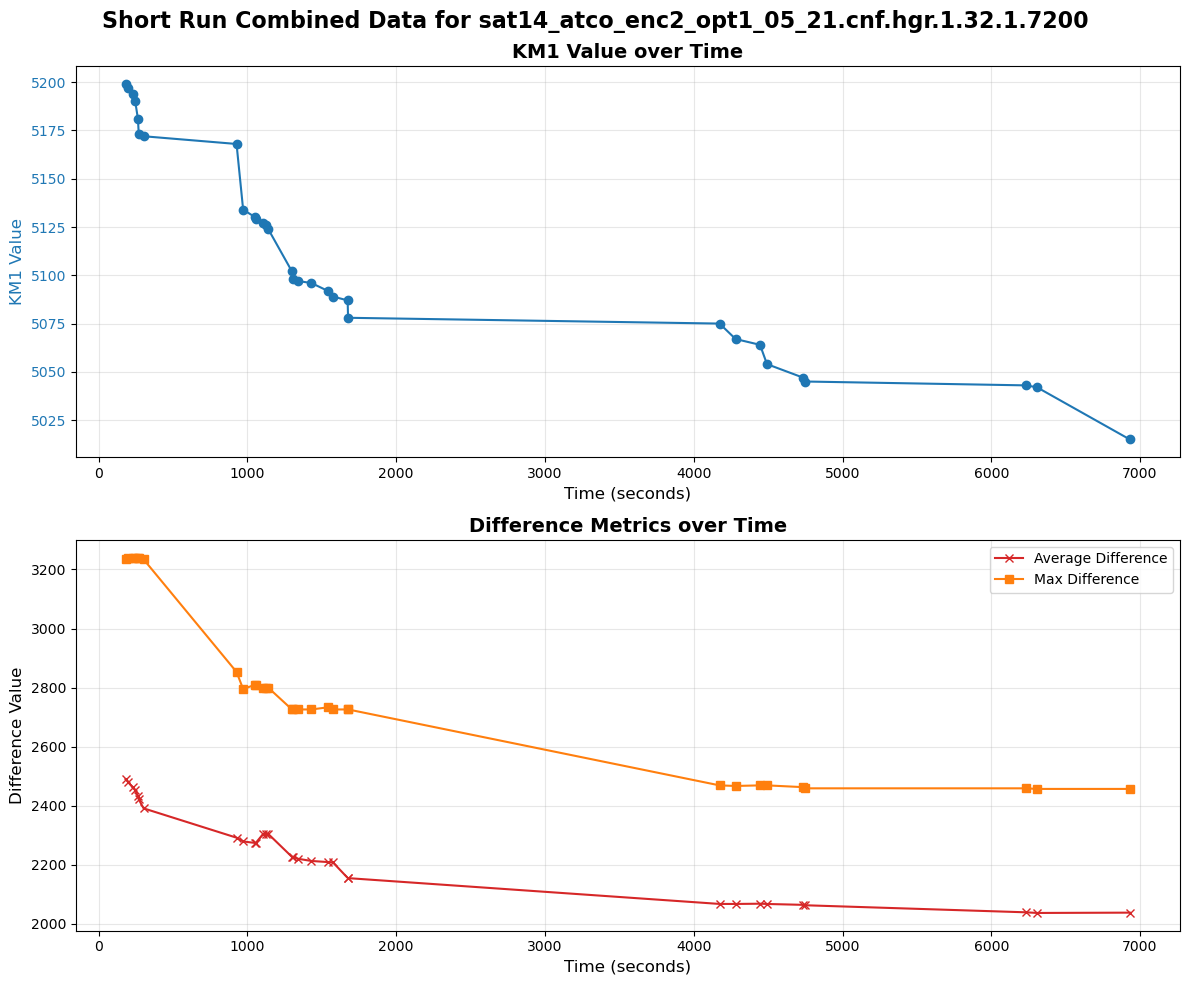

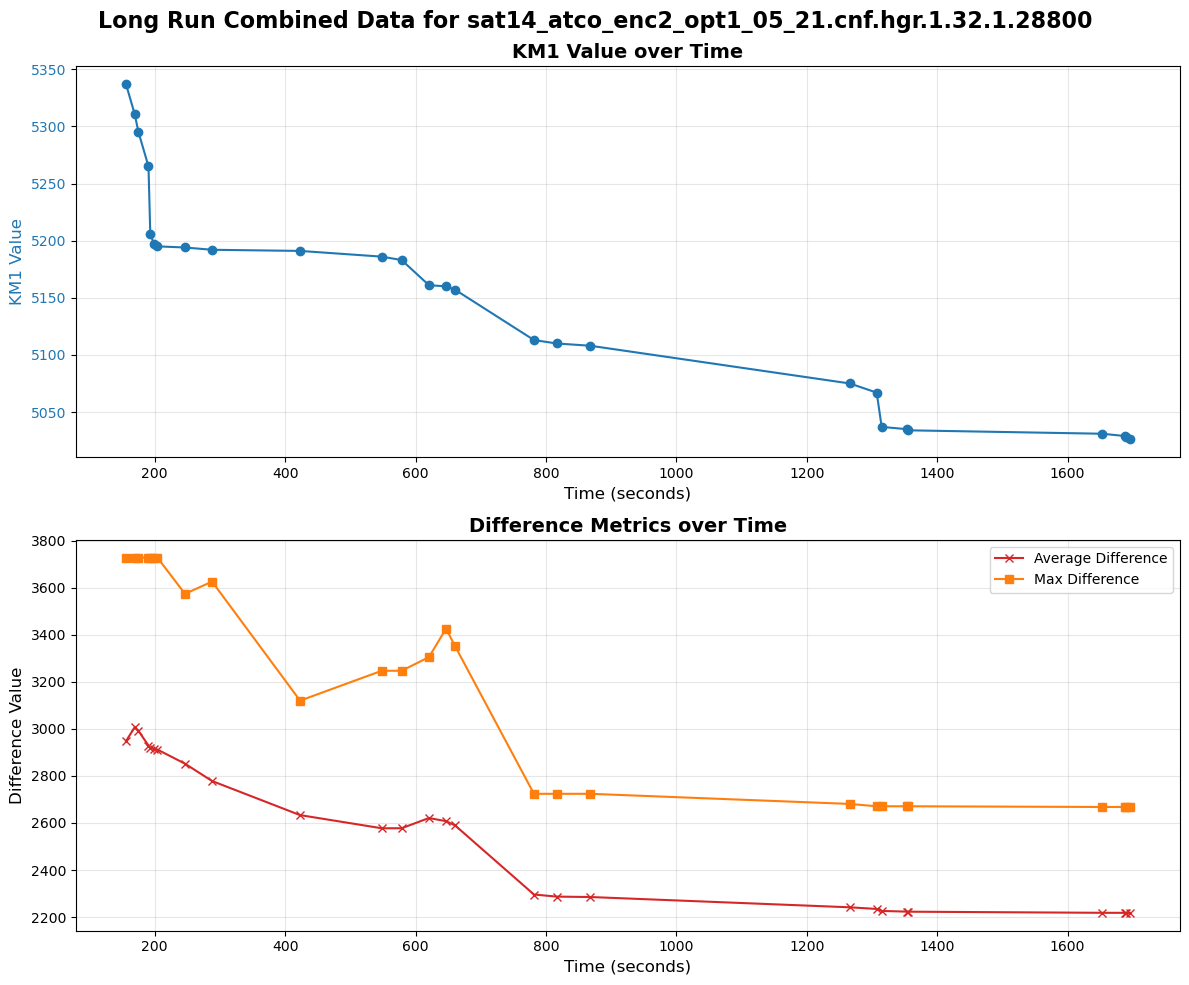

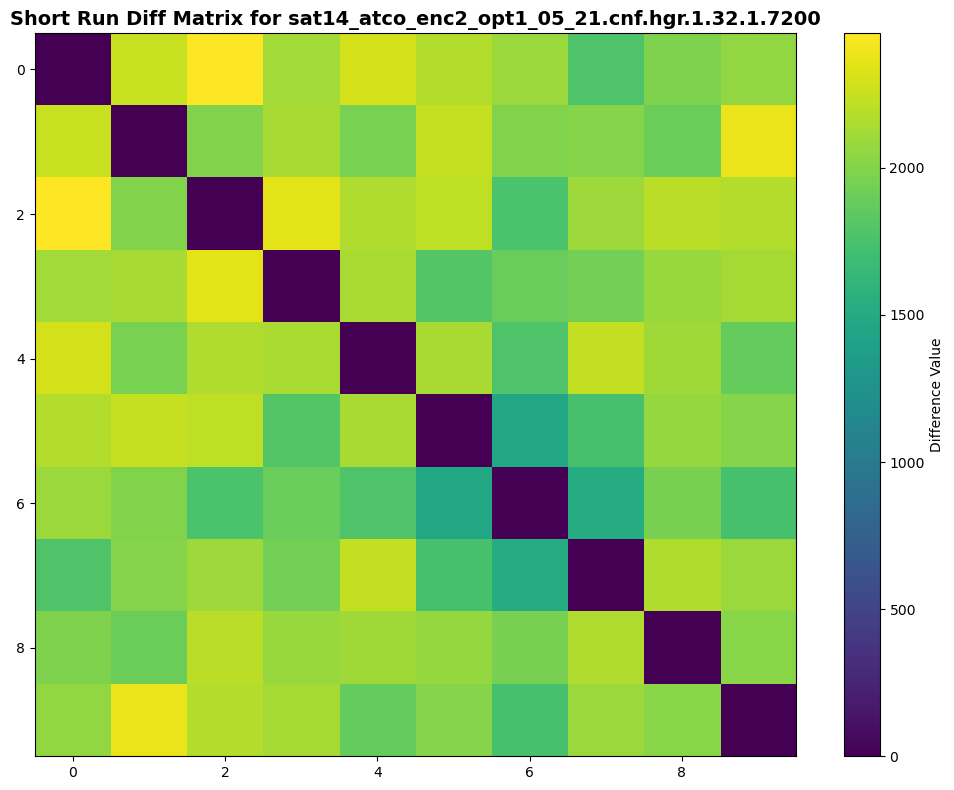

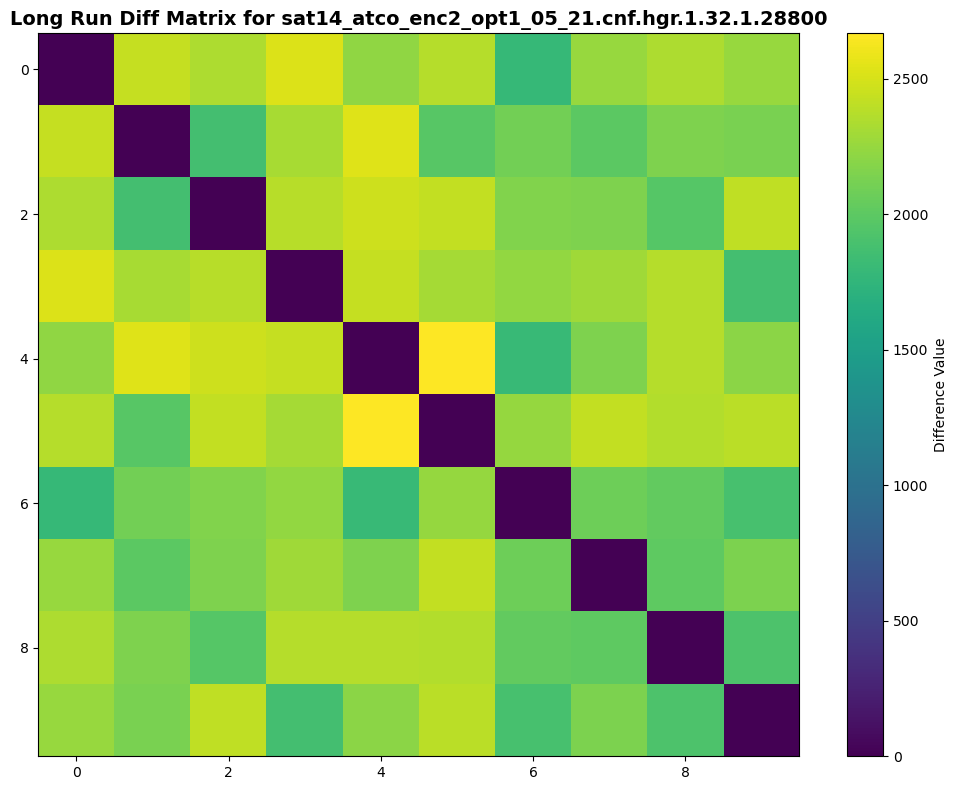

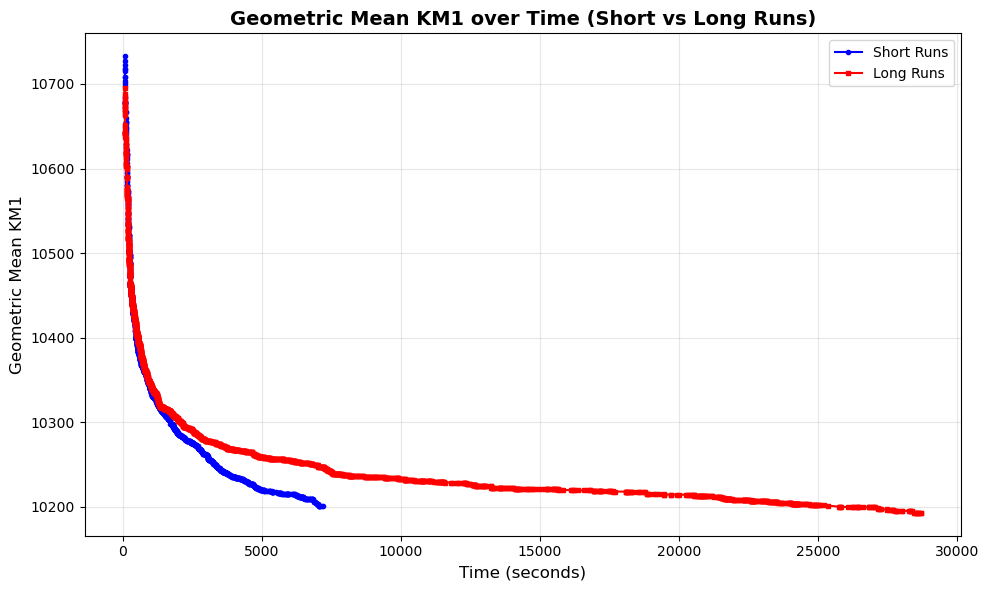

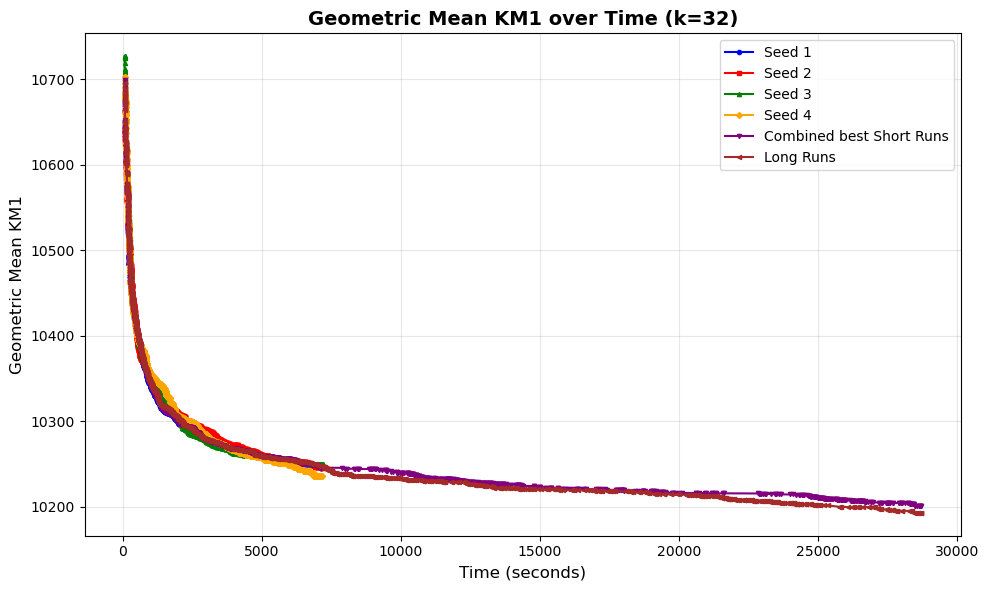

In [2]:
RESULT_FILES_DIR = f"{HOME_DIR}/Documents/experiment_results/2025-10-24_test_results/mt_kahypar_evo_results"
DIFF_FILES_DIR = f"{HOME_DIR}/Documents/experiment_results/2025-10-24_test_results/evo_diff_results"
HISTORY_FILES_DIR = f"{HOME_DIR}/Documents/experiment_results/2025-10-24_test_results/evo_results_results"

# Aggregate runs from result files
runs = aggregate_runs(RESULT_FILES_DIR)
k8_runs, k32_runs = split_runs_k_value(runs, '8', '32')

diff_array_k2 = []
for instance_name, results in k32_runs.items():
    short_km1 = results["short"]
    long_km1 = results["long"]
    if short_km1 is not None and long_km1 is not None:
        diff = long_km1 - short_km1
        diff_array_k2.append(diff)
diff_array_k8 = []
for instance_name, results in k8_runs.items():
    short_km1 = results["short"]
    long_km1 = results["long"]
    if short_km1 is not None and long_km1 is not None:
        diff = long_km1 - short_km1
        diff_array_k8.append(diff)

# How often is long run better than short runs (percentage)
if diff_array_k2:
    better_count = sum(1 for d in diff_array_k2 if d < 0)
    same_count = sum(1 for d in diff_array_k2 if d == 0)
    percentage_better = (better_count / len(diff_array_k2)) * 100
    percentage_same = (same_count / len(diff_array_k2)) * 100
    print(f"Percentage of instances where long run is better than short runs (k=32): {percentage_better:.2f}%")
    print(f"Percentage of instances where long run is the same as short runs (k=32): {percentage_same:.2f}%")
    # better_count_k8 = sum(1 for d in diff_array_k8 if d < 0)
    # percentage_better_k8 = (better_count_k8 / len(diff_array_k8)) * 100
    # print(f"Percentage of instances where long run is better than short runs (k=8): {percentage_better_k8:.2f}%")
else:
    print("No valid differences to analyze.")


# Get Geomean for short and long runs
short_km1_values_k32 = [km1["short"] for km1 in k32_runs.values() if km1["short"] is not None]
long_km1_values_k32 = [km1["long"] for km1 in k32_runs.values() if km1["long"] is not None]
if short_km1_values_k32 and long_km1_values_k32:
    geomean_short = geometric_mean(short_km1_values_k32)
    geomean_long = geometric_mean(long_km1_values_k32)
    print(f"Geometric Mean KM1 (k=32) - Short Runs: {geomean_short}, Long Runs: {geomean_long}")
    
short_km1_values_k8 = [km1["short"] for km1 in k8_runs.values() if km1["short"] is not None]
long_km1_values_k8 = [km1["long"] for km1 in k8_runs.values() if km1["long"] is not None]
if short_km1_values_k8 and long_km1_values_k8:
    geomean_short_k8 = geometric_mean(short_km1_values_k8)
    geomean_long_k8 = geometric_mean(long_km1_values_k8)
    print(f"Geometric Mean KM1 (k=8) - Short Runs: {geomean_short_k8}, Long Runs: {geomean_long_k8}")

# Analyze largest relative differences (in favor of long runs)
relative_diffs = []
for run, km1 in k32_runs.items():
    short_km1 = km1["short"]
    long_km1 = km1["long"]
    if short_km1 is not None and long_km1 is not None:
        diff = long_km1 - short_km1
        relative_diff = diff / short_km1
        relative_diffs.append((run, relative_diff))
relative_diffs.sort(key=lambda x: x[1], reverse=True)
print("relative differences: ", relative_diffs[:10])


# Diff Matrices Analysis
diff_runs = aggregate_diff_runs(DIFF_FILES_DIR)

# Analyze diff matrices for worst long runs
show_full_history = False

history_runs = aggregate_history_runs(HISTORY_FILES_DIR, full_history=show_full_history)
for run, _ in relative_diffs[:10]:
    short_instance = f"{run}.{SHORT_TIMELIMIT}"
    long_instance = f"{run}.{LONG_TIMELIMIT}"   
    if short_instance in diff_runs and long_instance in diff_runs:
        
        short_matrices = diff_runs[short_instance]
        long_matrices = diff_runs[long_instance]

        if len(long_matrices[0]['matrices']) == 0:
            continue
        if len(short_matrices[0]['matrices']) == 0:
            continue

        best_short_matrices = get_diff_matrices_for_best_run(history_runs, short_matrices, short_instance)
        last_short_matrix = best_short_matrices[-1] if best_short_matrices else None
        last_long_matrix = long_matrices[0]['matrices'][-1]
        
        long_diff_run = long_matrices[0]['matrices']
        short_diff_run = best_short_matrices
        short_history_run = history_runs[short_instance]['history']
        long_history_run = history_runs[long_instance]['history']
        
        combined_short = combine_history_and_diff(short_history_run, short_diff_run)
        combined_long = combine_history_and_diff(long_history_run, long_diff_run)
        plot_combined_data(combined_short, title=f"Short Run Combined Data for {short_instance}")
        plot_combined_data(combined_long, title=f"Long Run Combined Data for {long_instance}")

        if last_short_matrix and last_long_matrix:
            plot_single_matrix(last_short_matrix, title=f"Short Run Diff Matrix for {short_instance}")
            plot_single_matrix(last_long_matrix, title=f"Long Run Diff Matrix for {long_instance}")
        
# Geometric Mean over all instances
short_history_runs, long_history_runs = split_long_short_history_runs(history_runs)
short_k8_runs, short_k32_runs = split_k_value_history_runs(short_history_runs, '8', '32')
long_k8_runs, long_k32_runs = split_k_value_history_runs(long_history_runs, '8', '32')
geomean_short = create_geomean_over_all_instances(short_k32_runs)
geomean_long = create_geomean_over_all_instances(long_k32_runs)
# 2 Graphs
# plot_time_series(geomean_short, title="Geometric Mean KM1 over Time (Short Runs)")
# plot_time_series(geomean_long, title="Geometric Mean KM1 over Time (Long Runs)")
# Both in 1 Graph
plot_time_series(geomean_short, geomean_long, 
                 title="Geometric Mean KM1 over Time (Short vs Long Runs)",
                 labels=['Short Runs', 'Long Runs'])

# Show full history
show_full_history = True
history_runs = aggregate_history_runs(HISTORY_FILES_DIR, full_history=show_full_history)
short_history_runs_full, _ = split_long_short_history_runs(history_runs)
_, short_k32_runs_full = split_k_value_history_runs(short_history_runs_full, '8', '32')
all_seeds_short_histories_k32 = split_seed_history_runs(short_k32_runs_full)

fixed_short_history_runs = make_history_runs_sequential(*all_seeds_short_histories_k32, time_limit=SHORT_TIMELIMIT)
fixed_geomean_short = create_geomean_over_all_instances(fixed_short_history_runs)

geomean_for_all_seeds = []
for seed_runs in all_seeds_short_histories_k32:
    geomean = create_geomean_over_all_instances(seed_runs)
    geomean_for_all_seeds.append(geomean)
plot_time_series(*geomean_for_all_seeds, fixed_geomean_short, geomean_long,
                 title="Geometric Mean KM1 over Time (k=32)",
                 labels=[f'Seed {i+1}' for i in range(len(geomean_for_all_seeds))] + ['Combined best Short Runs', 'Long Runs'])


